### Looking at Data - Determining Accuracy

In [7]:
import numpy as np
def findStartStopRegions(predClasses):
    '''
    Finds start and stop regions for each intubation trial
    Arguments: 
        predClasses -- A class prediction for each timestep (either 0: idle/no intubation,
        1: intubation, or 2: boundary)
    Returns:
        startRegions: list of start and end indexes for regions classified at start regions
        stopRegions: list of start and end indexes for regions classified at stop regions
    '''
    
    L = len(predClasses)
    
    startTransitionMask = (predClasses == 2)
    stopTransitionMask = (predClasses == 3)
    
    possibleStartRegions = []
    possibleStopRegions = []
    start1 = None
    start = None
    
    # Loop through all timesteps of trial
    for t in range(L):
        if startTransitionMask[t] and start1 is None:
            start1 = t
        # If no longer in transition region but the region started
        elif (not startTransitionMask[t]) and start1 is not None:
            # Append the region and reset start to None 
            possibleStartRegions.append((start1, t-1))
            start1 = None
            
        if stopTransitionMask[t] and start is None:
            start = t
        # If no longer in transition region but the region started
        elif (not stopTransitionMask[t]) and start is not None:
            # Append the region and reset start to None 
            possibleStopRegions.append((start, t-1))
            start = None
    
    # Take care of the last section of the trial       
    # if start is not None: 
    #     possibleStartRegions.append((start, L-1))
        
     # Now specifically classify all regions as either start or stop regions
    startRegions = []
    stopRegions = [] 
    
    # Loop through start and end of each identified region
    identifiedStart = False
    identifiedStop = False
    for (s,e) in possibleStartRegions:
        before = np.round(np.mean(predClasses[s - 51:s - 1])) if s > 50 else None
        after = np.round(np.mean(predClasses[e + 1:e + 51])) if e < L - 51 else None
        
        if before == 0 and after == 1:
            startRegions.append((s,e))
            identifiedStart = True
        
    for (s,e) in possibleStopRegions:
        before = np.round(np.mean(predClasses[s - 51:s - 1])) if s > 50 else None
        after = np.round(np.mean(predClasses[e + 1:e + 51])) if e < L - 51 else None
        
        if before == 1 and after == 0:
            stopRegions.append((s,e))
            identifiedStop = True
            
       
            
    return possibleStartRegions, possibleStopRegions

def pickStrongRegion(regions, avgProbs, classIdx):
    
    bestRegion = None
    bestAvgProb = -1
    
    for (s,e) in regions:
        regionAvgProb = np.mean(avgProbs[s:e+1, classIdx])
        if regionAvgProb > bestAvgProb:
            bestAvgProb = regionAvgProb
            bestRegion = (s,e)
            
    return bestRegion

def findCenter(region):
    if region is None:
        return None
    s, e = region
    center = (s + e) // 2
    return center

def predLabels(predictedStart, predictedStop, L):
    timestepLevelLabelPred = np.zeros(L, dtype=int)
    if predictedStart is not None and predictedStop is not None:
        timestepLevelLabelPred[predictedStart:predictedStop + 1] = 1
    return timestepLevelLabelPred


def fill_nans_with_next(x):
    """
    Fill NaNs in a 1D array with the closest *next* non-NaN value.
    Trailing NaNs (with no next value) stay NaN.
    """
    x = np.asarray(x, dtype=float).copy()
    last = np.nan
    # walk backwards so "last" always holds the next non-NaN going forward
    for i in range(len(x) - 1, -1, -1):
        if np.isnan(x[i]):
            x[i] = last
        else:
            last = x[i]
    return x

## Overlapping Tx=128

In [ ]:
# OVERLAPPING TX=128, SRIDE=32 OR 1
import json
import numpy as np
import matplotlib.pyplot as plt

# Load trial length map

Y_test = np.load('AWS_Run\\OverlappingDataWithDiffStrides\\Y_test.npy')
trialIDs_test = np.load('AWS_Run\\OverlappingDataWithDiffStrides\\trial_ids_test.npy', allow_pickle=True)
predictions = np.load('AWS_Run\\OverlappingDataWithDiffStrides\\predictions_arch1.npz', allow_pickle=True)

predClassesPerWindow = predictions["pred_classes"]
predConfPerWindow = predictions["pred_confidences"]
Y_windowLabels_test = predictions["Y_windowLabels_test"]
precentageWindowMatch = np.mean(predClassesPerWindow == Y_windowLabels_test) * 100
print(f"Window-level accuracy: {precentageWindowMatch:.2f}%")

allLabelPred = []
allDistStart = []
allDistStop = []
percentageMatchSum = 0
count = 0
lengths = []
# Loop through each trial              
for trial in np.unique(trialIDs_test):
    data = np.load(f'AWS_Run\\OverlappingDataWithDiffStrides\\trialProbs_arch1/trial_{trial}.npz')
    avgProbs = data["avgProbs"]      # (L, 3): predicted probs per timestep
    counts = data["counts"]          # (L,)
    avgTrue = data["avgTrue"]        # could be (L,) or (L, 3)
    countsTrue = data["countsTrue"]  # (L,)
    predClassesPerWindow = data["predClassesPerWindow"]
    predConfPerWindow = data["predConfPerWindow"]
    Y_windowLabels_test = data["Y_windowLabels_test"]
    L = int(data["length"])
    
    lengths.append(L)
    
    predClasses = np.argmax(avgProbs, axis=1)
    trueClasses = avgTrue  
    
    trueClasses = fill_nans_with_next(trueClasses)
    
    # indices = np.arange(len(trueClasses))
    # goodIdxs = ~np.isnan(trueClasses)
    # trueClasses[~goodIdxs] = np.interp(indices[~goodIdxs], indices[goodIdxs], trueClasses[goodIdxs])

    # print(avgProbs.shape)
    maxProbIdx = np.argmax(avgProbs, axis=0)

    # Sanity checks
    assert predClasses.shape == (L,)
    assert trueClasses.shape == (L,)
    
    # Compare percentages timesteps in a trial that predClass matches trueClass (BEFORE Post-processing)
    percentageMatch = np.mean(predClasses == trueClasses) * 100
    percentageMatchSum = percentageMatchSum + percentageMatch
    count = count + 1
    
    

percentageMatchAvg = percentageMatchSum / count
print(f"Average Binary Timestep Accuracy Before Post-Processing: {percentageMatchAvg:.2f}%")




Window-level accuracy: 67.58%
Average Binary Timestep Accuracy Before Post-Processing: 81.28%


Window-level accuracy: 68.80%


C:\Users\olivi\AppData\Local\Temp\ipykernel_33360\203840646.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12,4))


Average Binary Timestep Accuracy Before Post-Processing: 77.16%


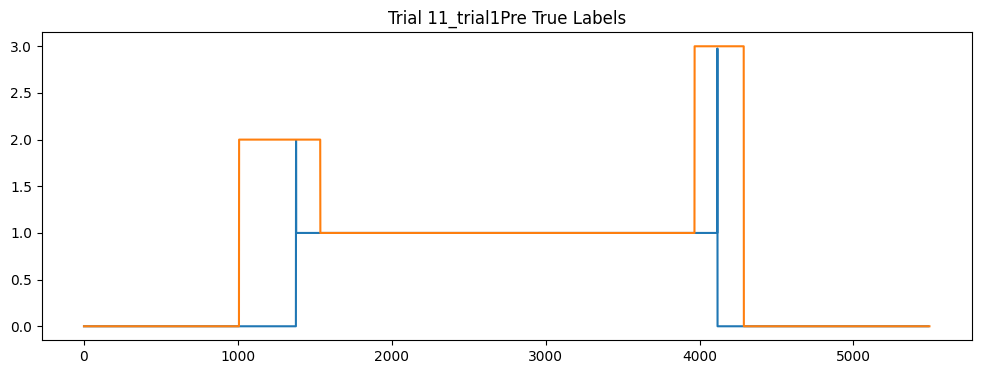

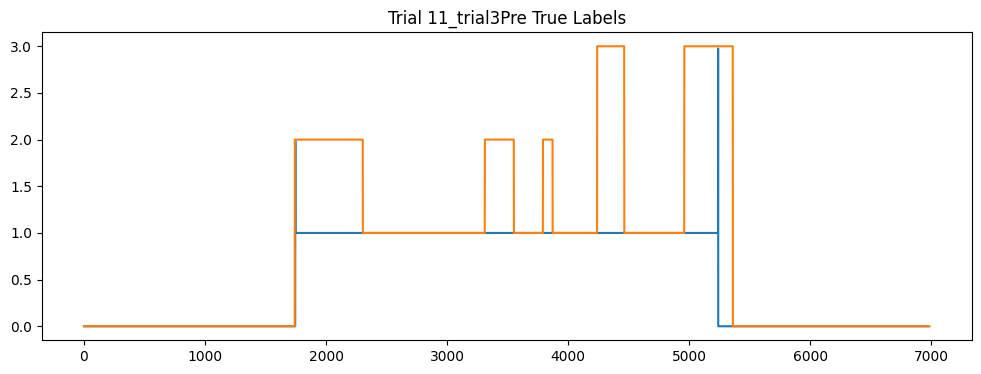

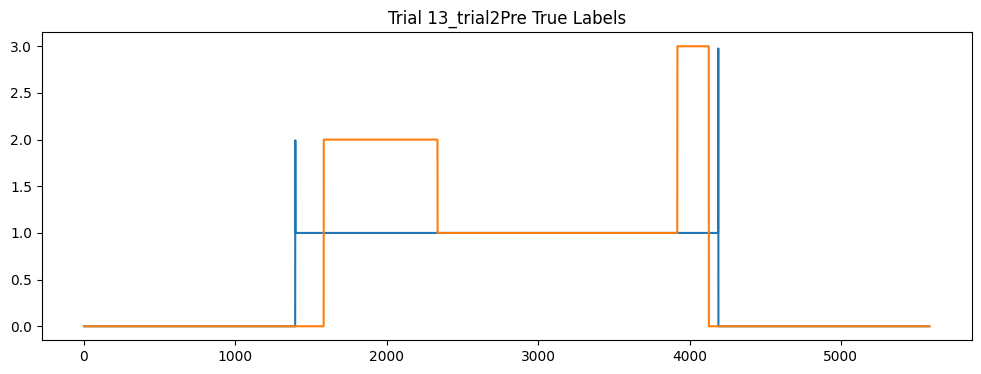

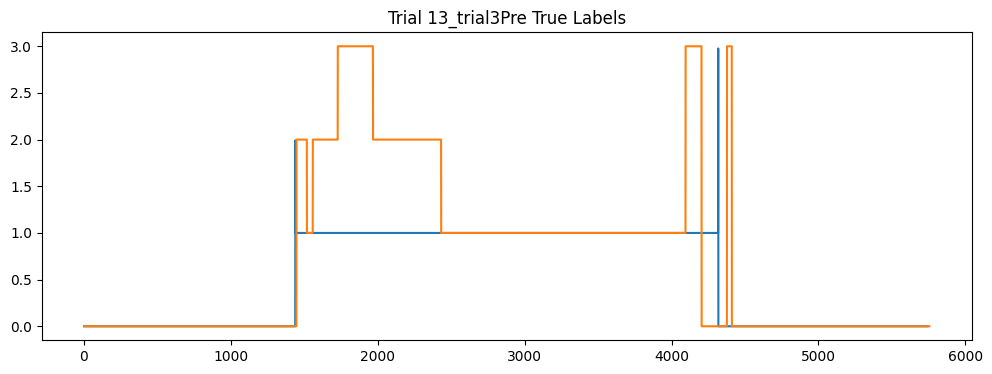

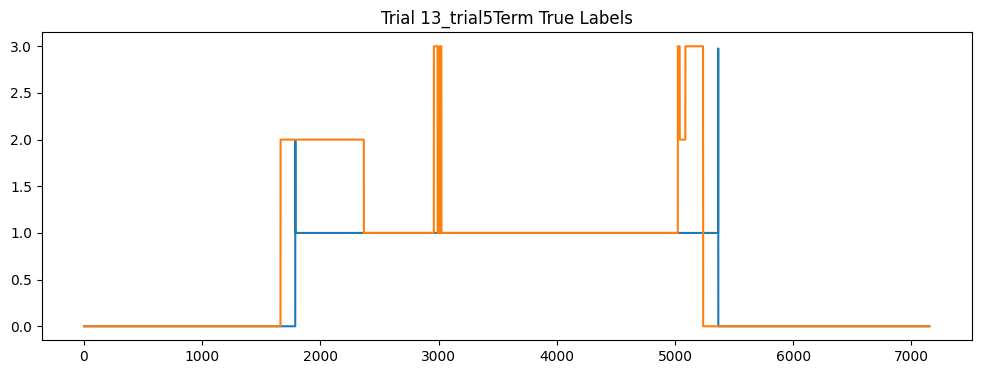

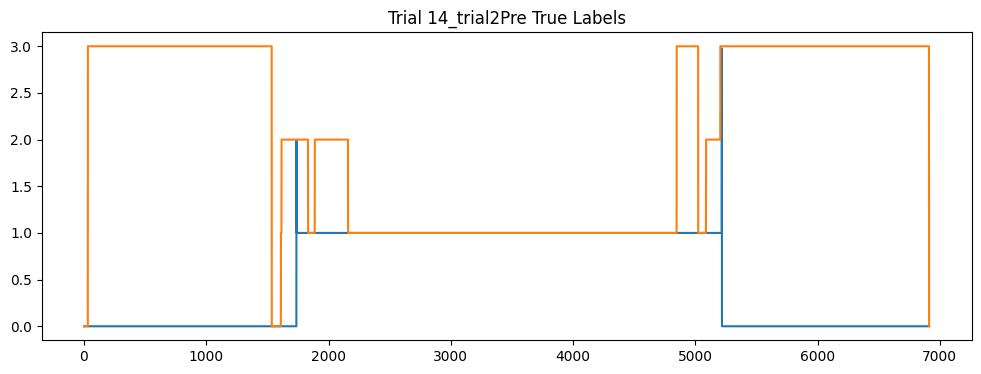

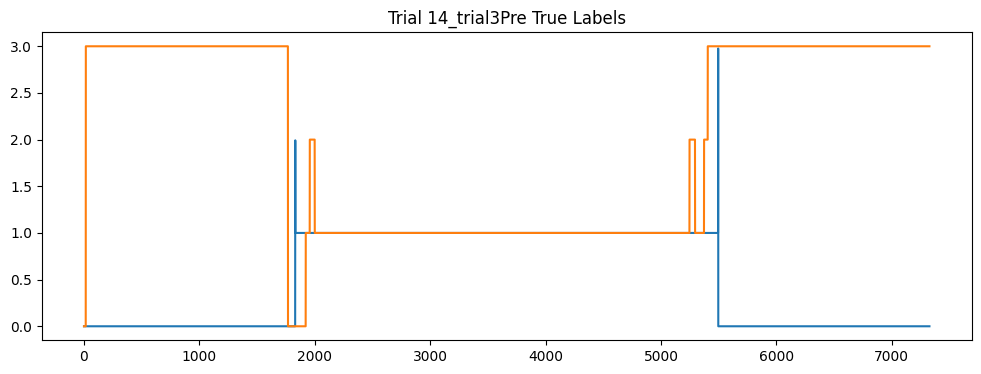

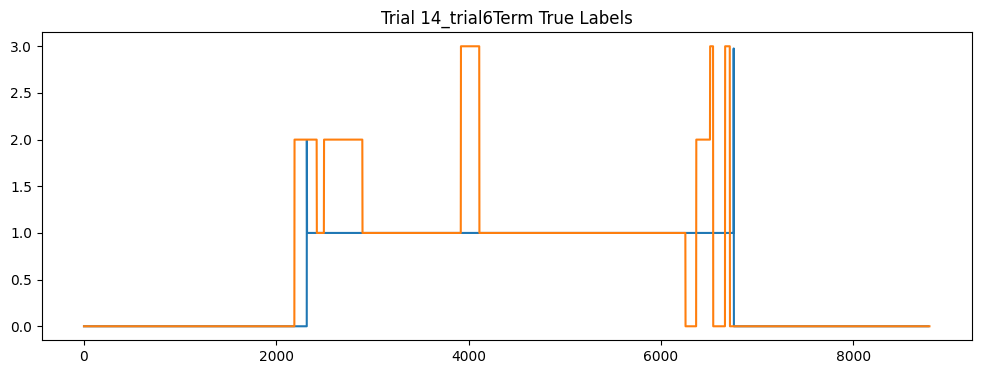

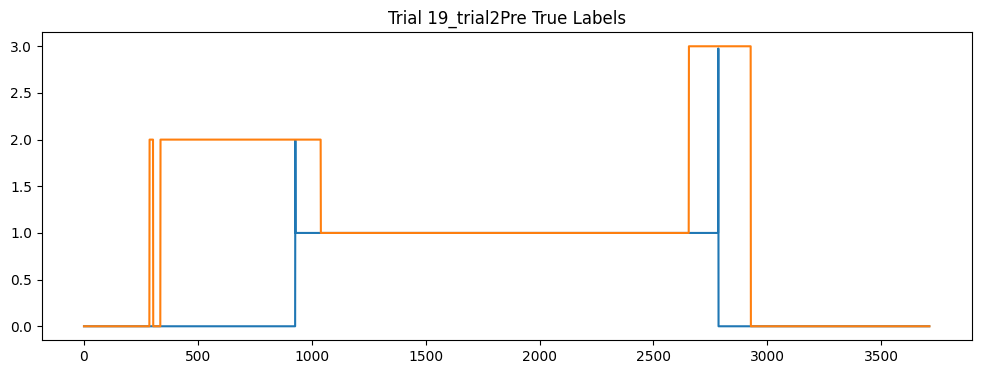

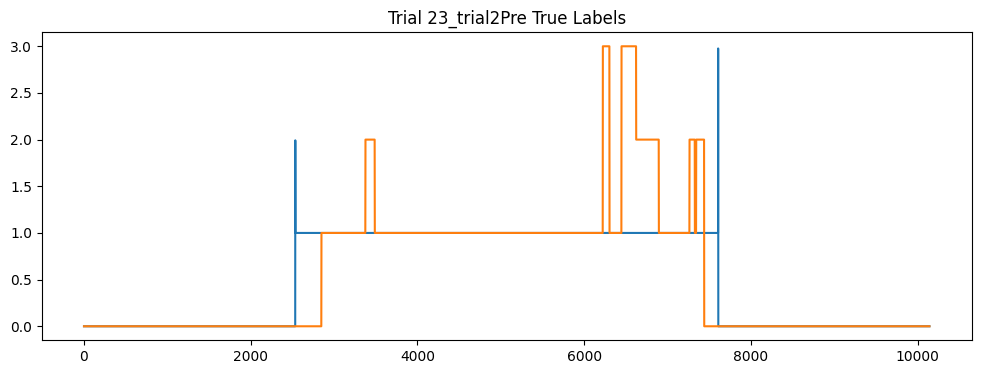

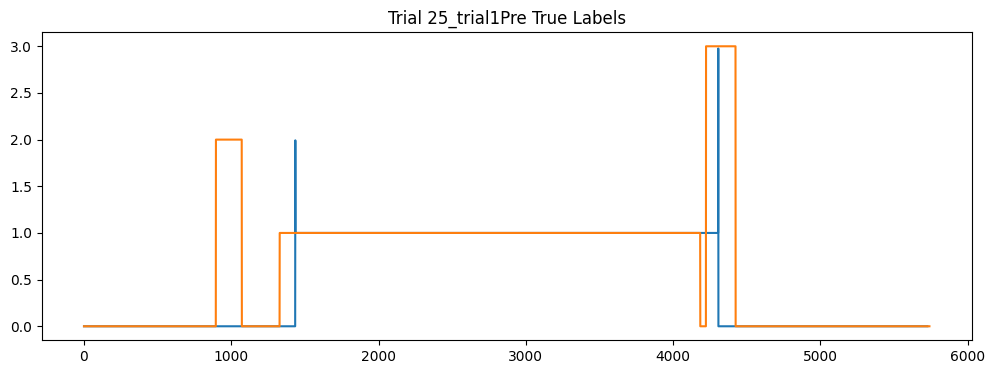

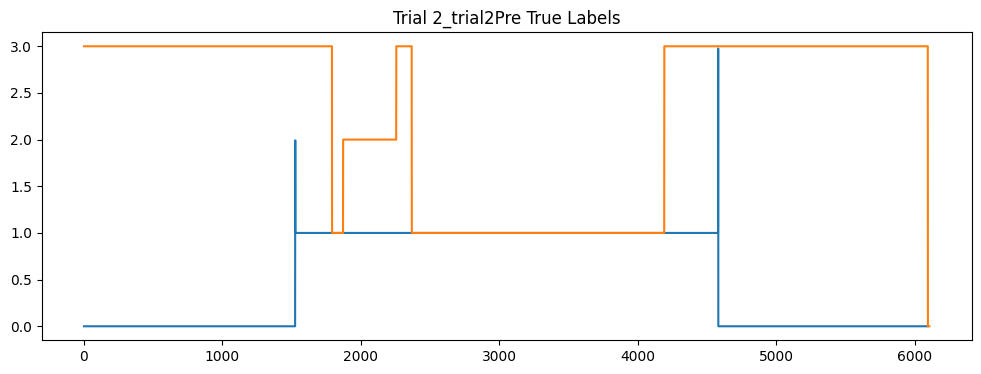

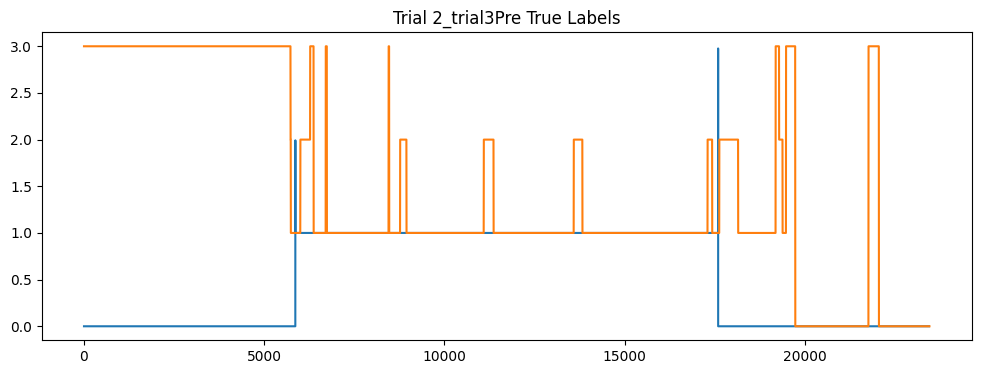

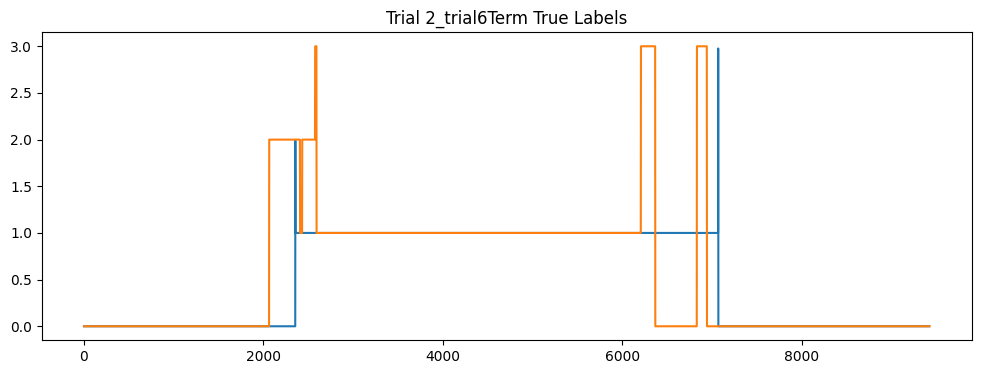

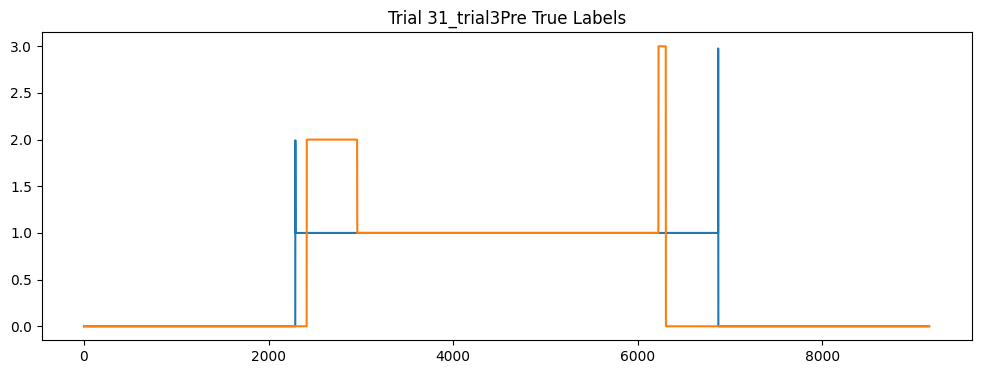

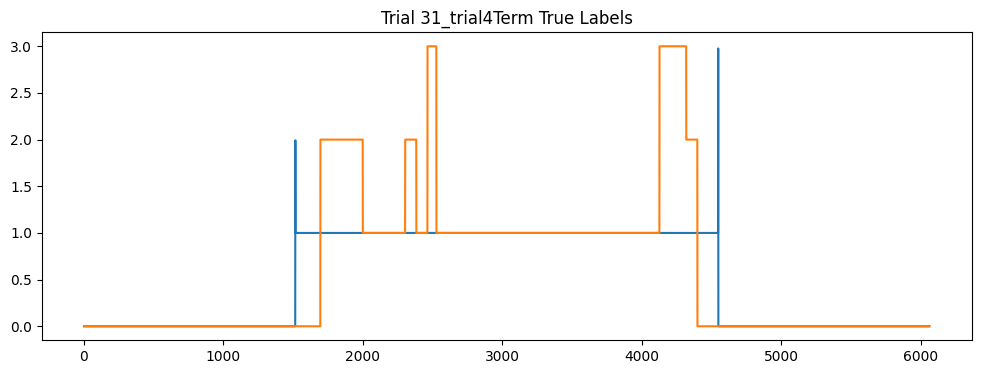

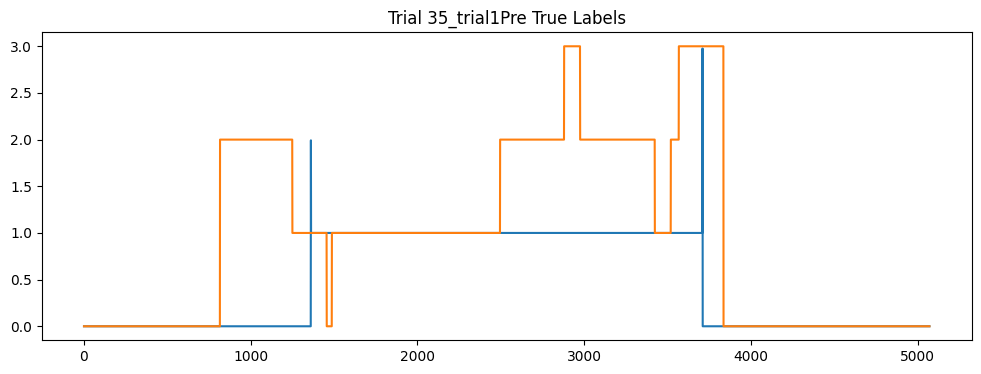

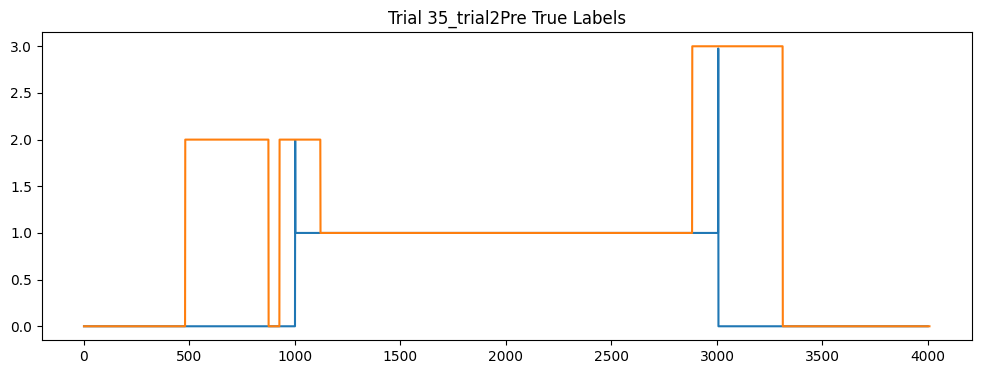

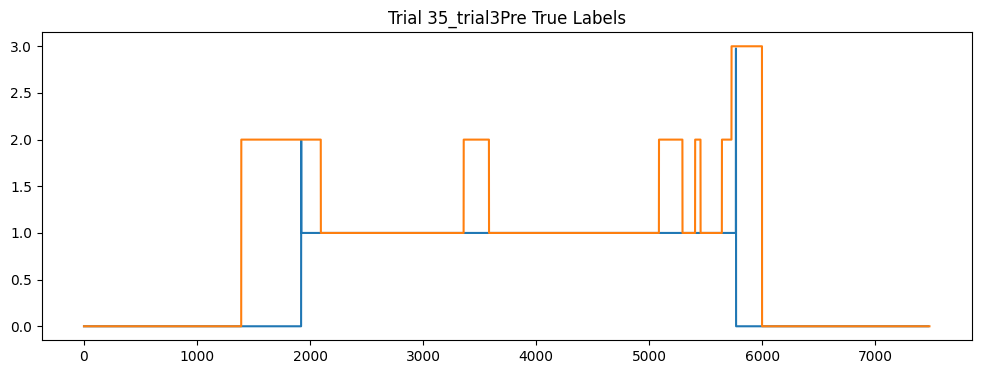

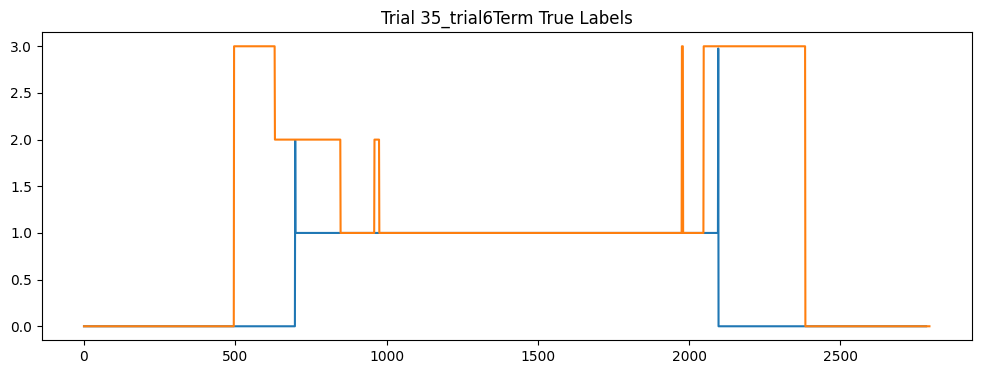

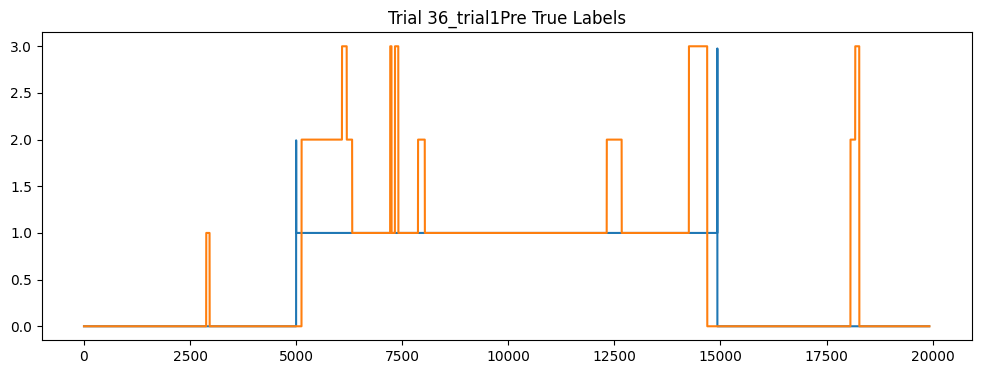

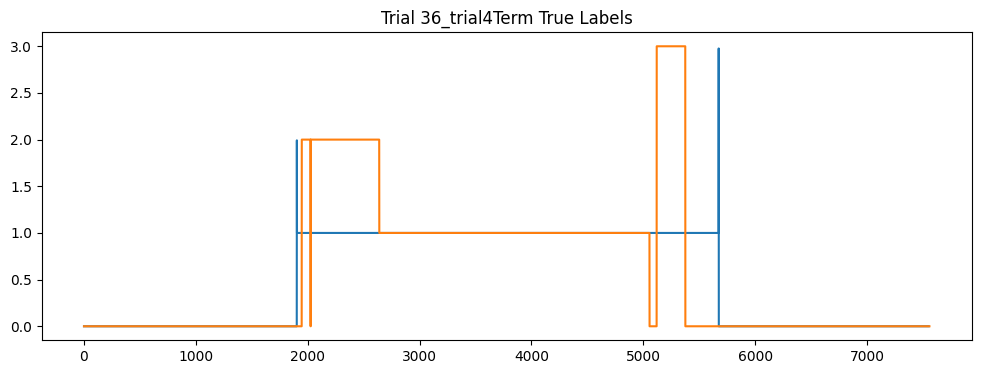

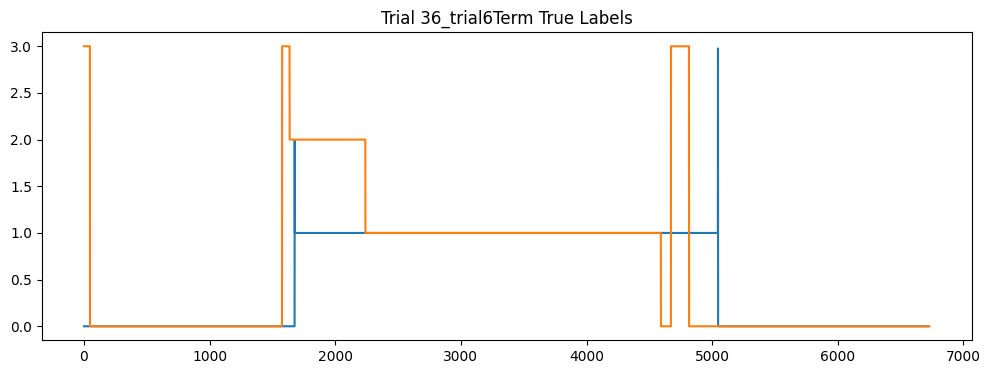

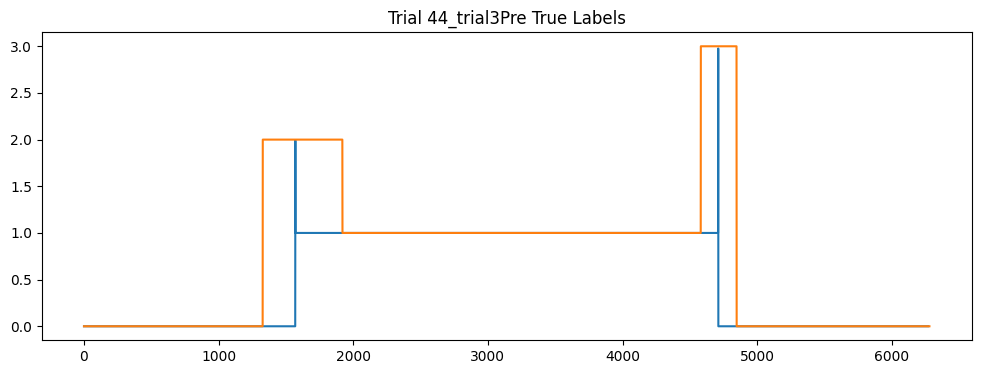

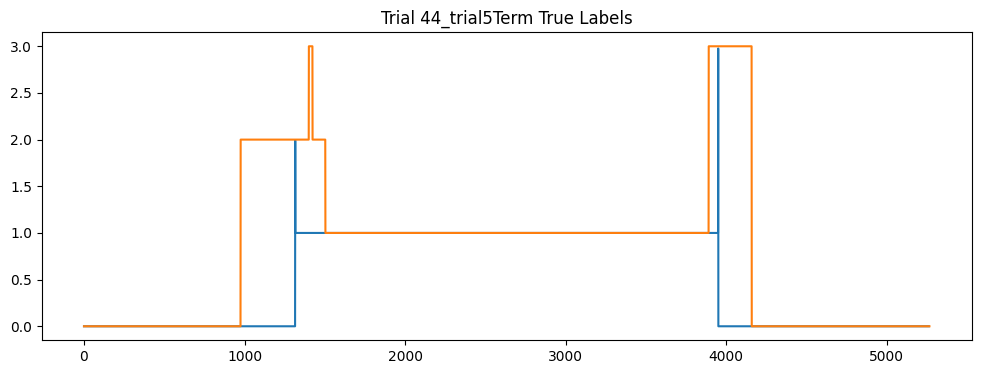

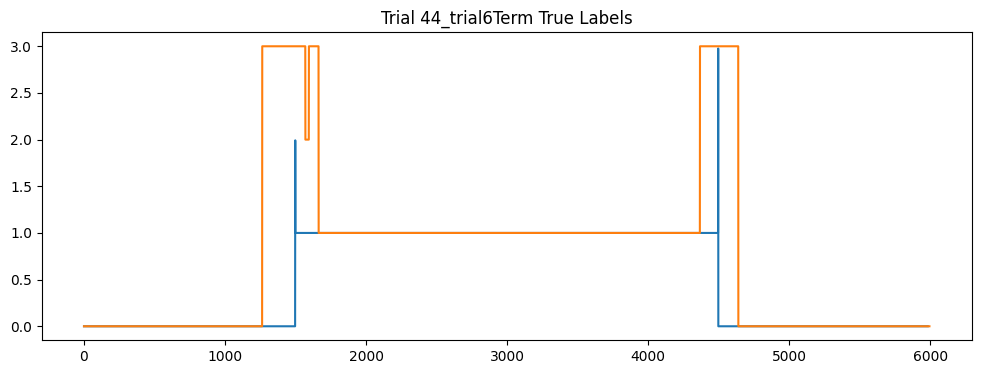

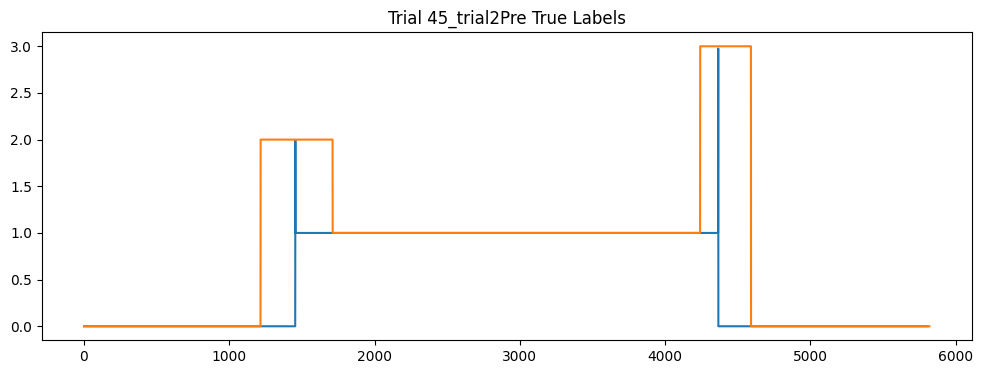

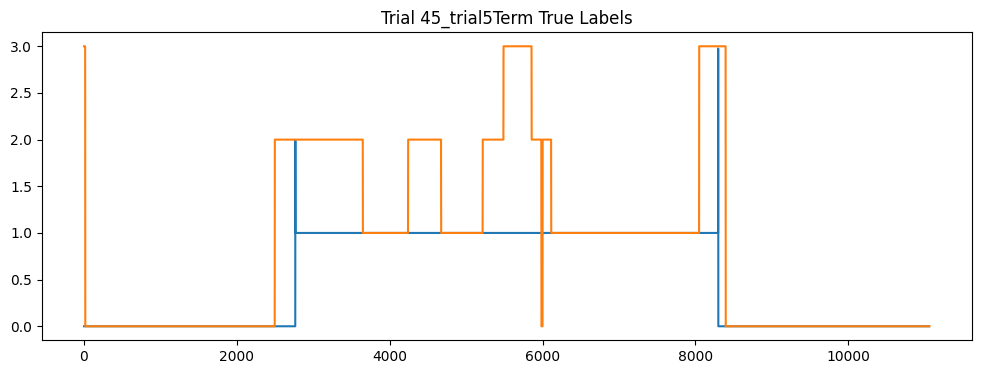

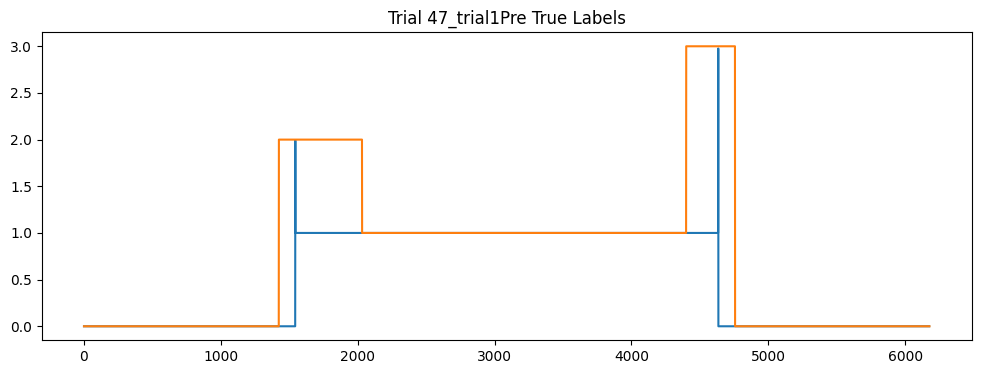

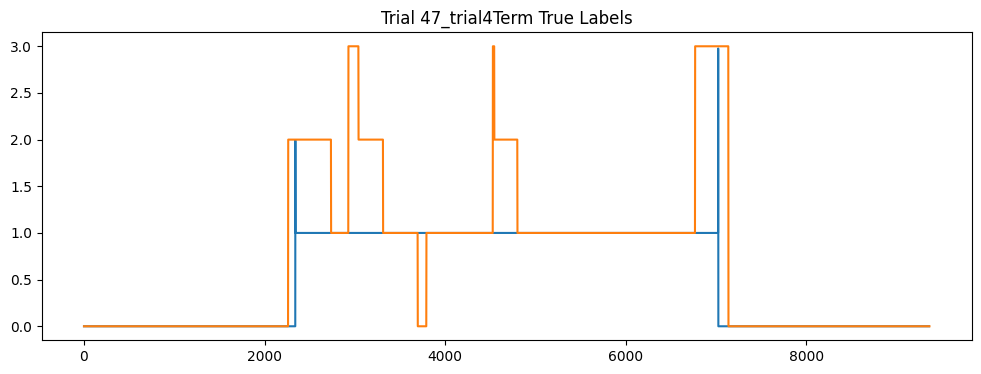

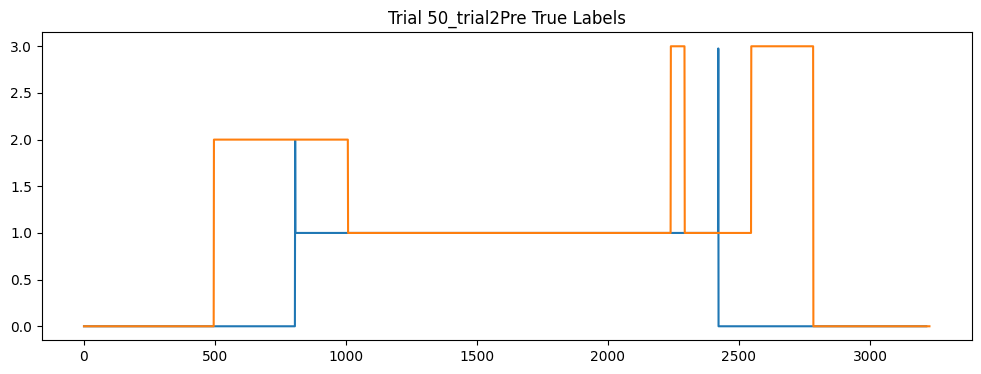

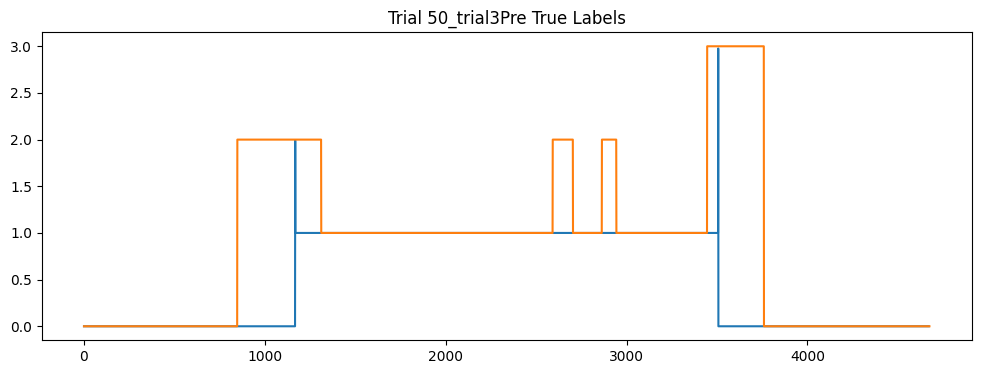

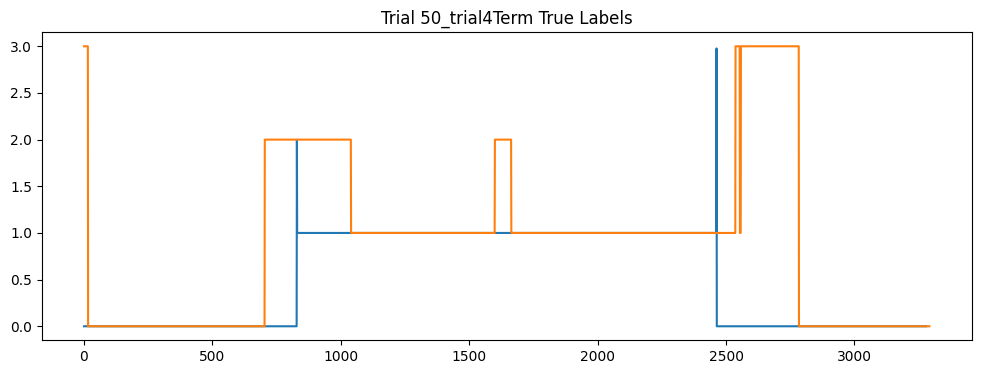

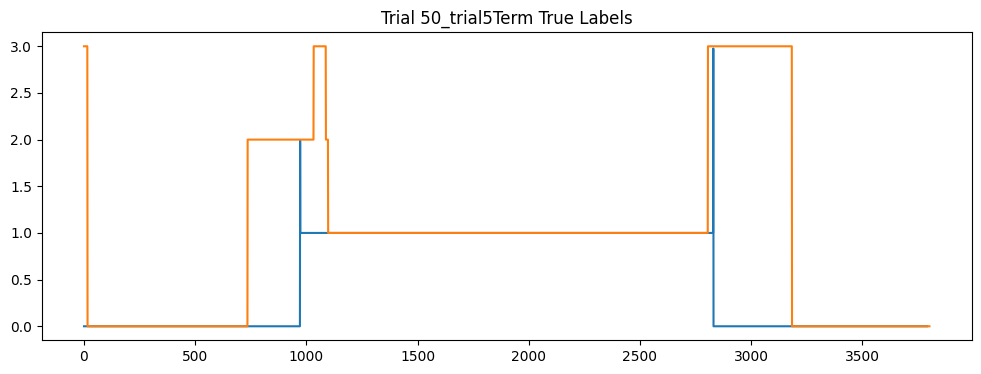

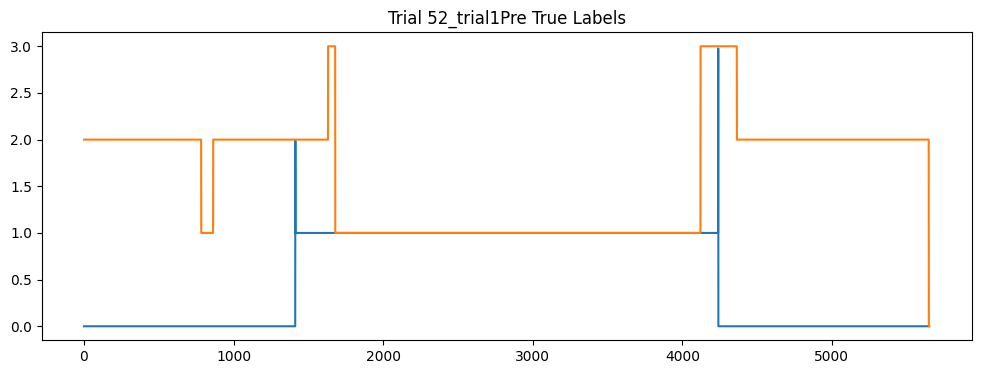

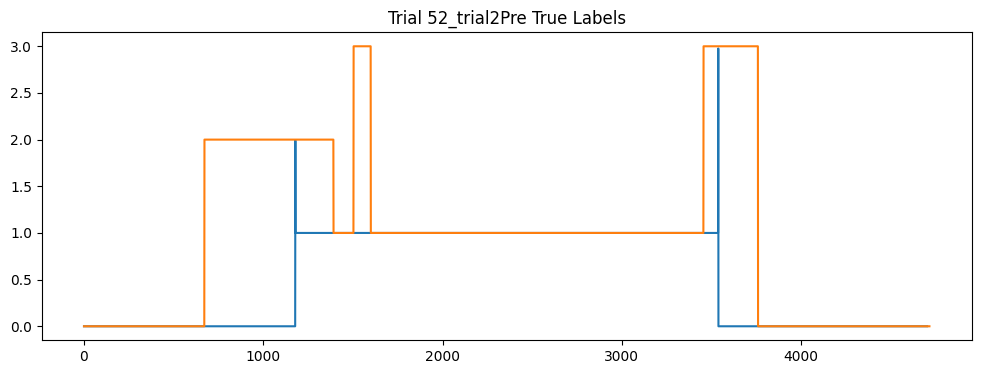

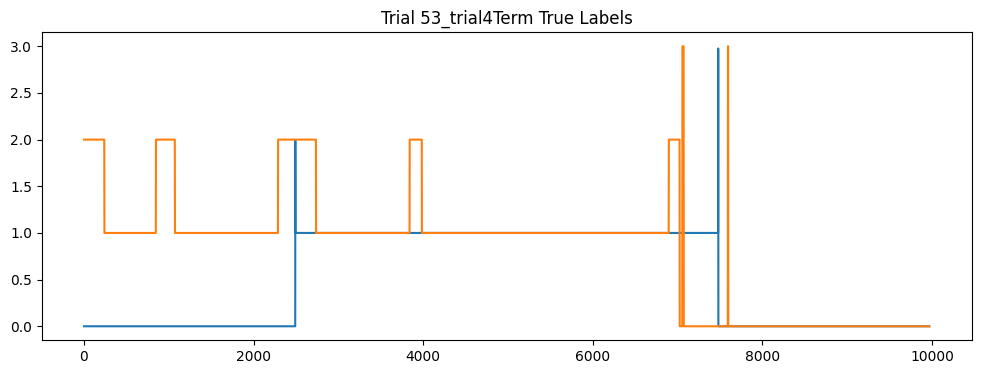

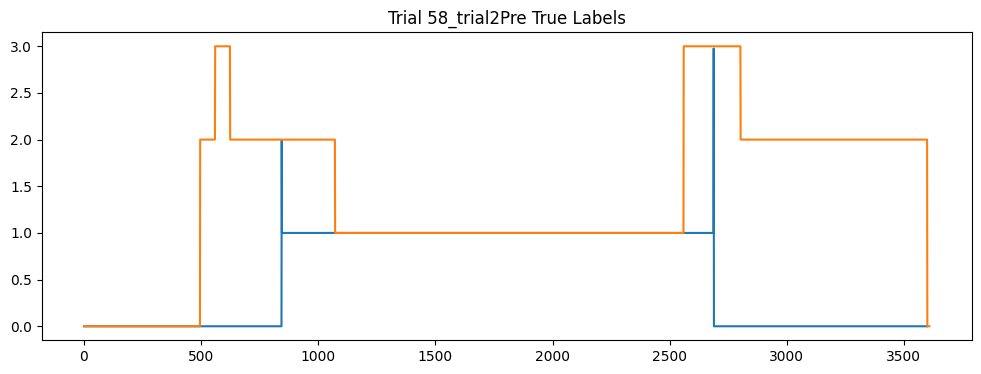

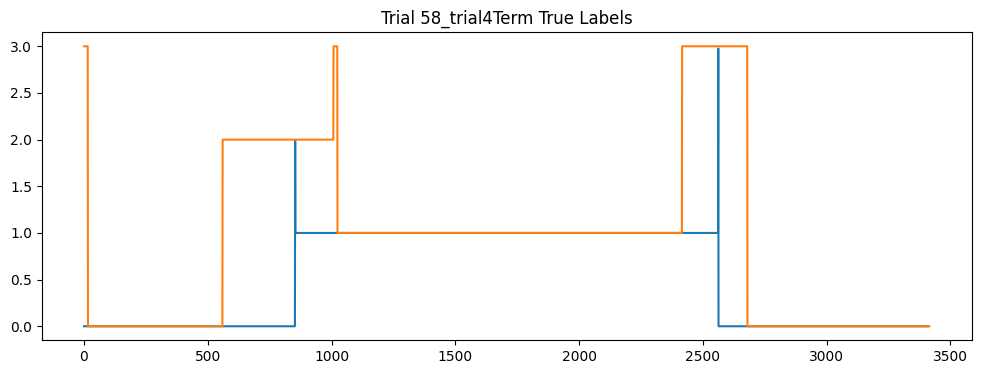

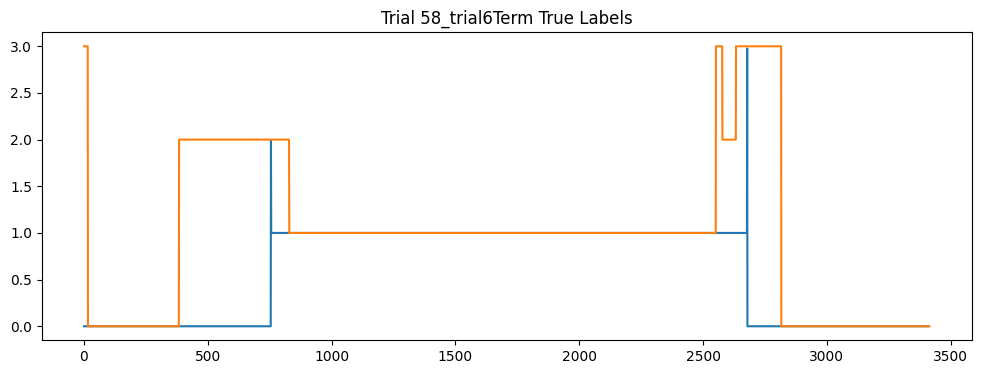

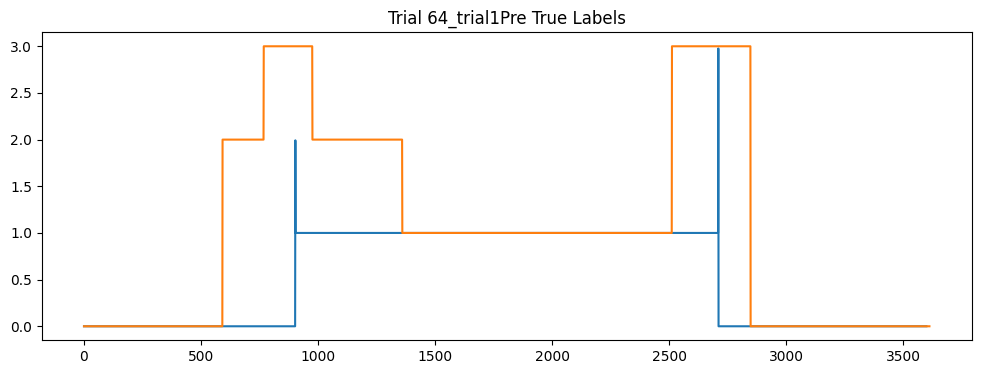

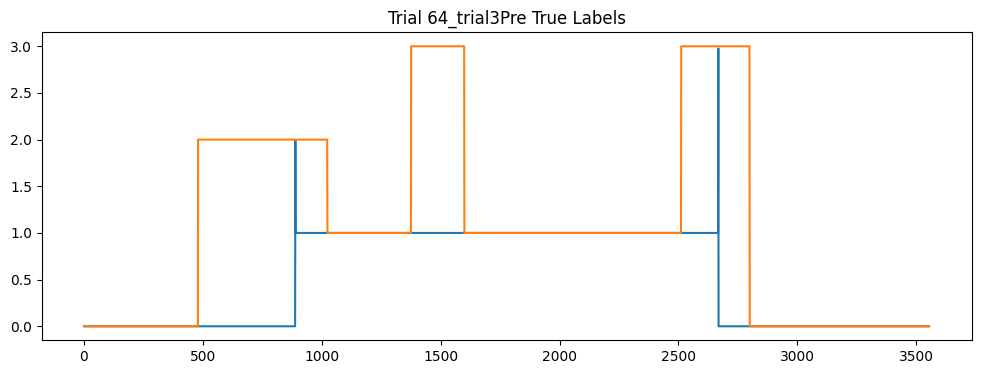

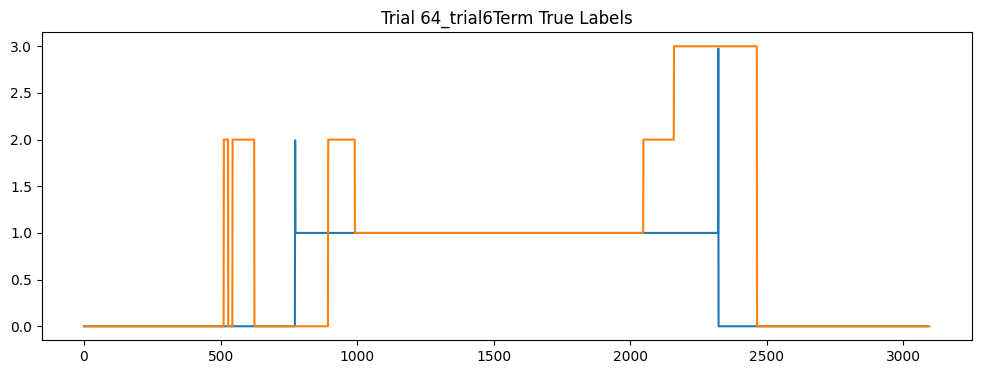

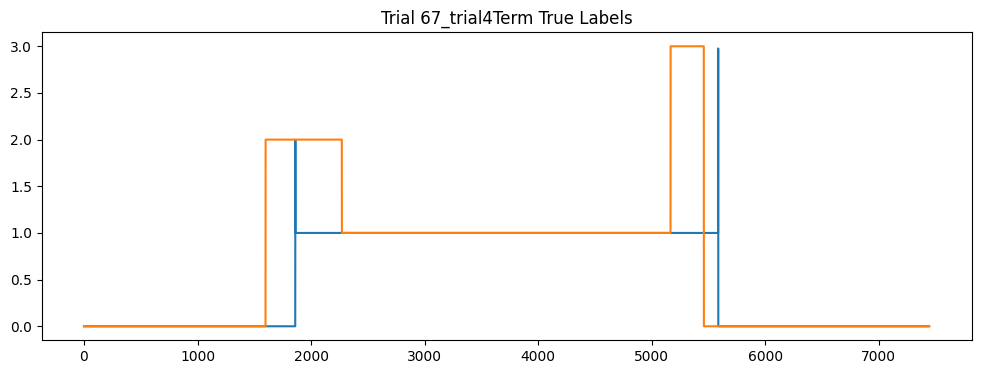

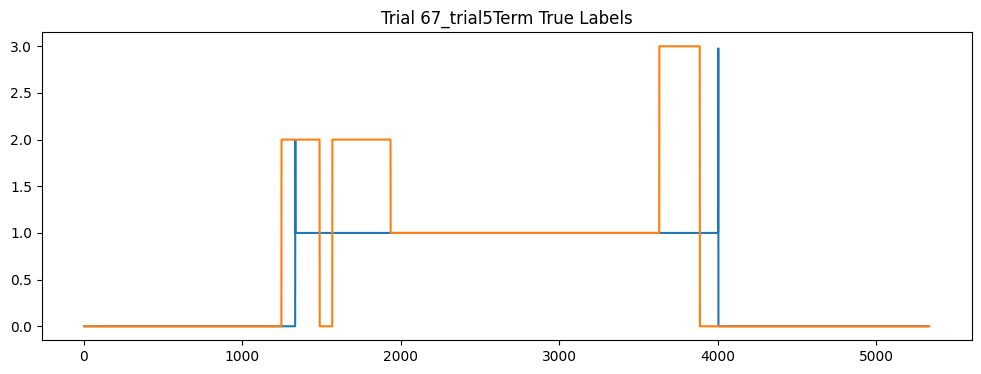

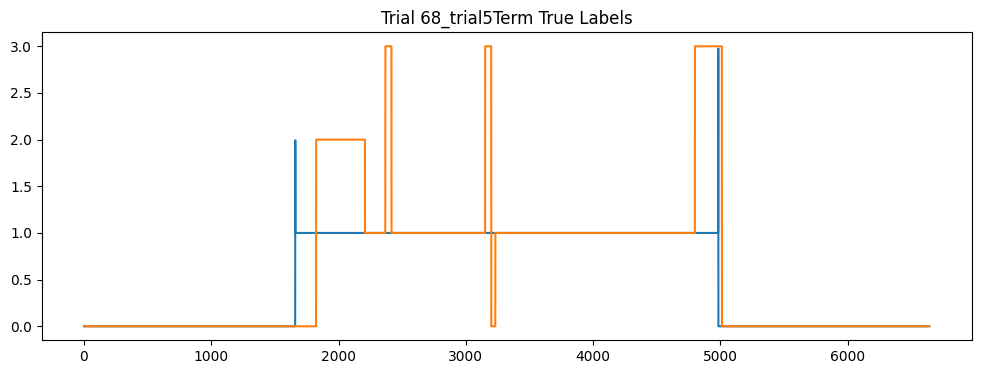

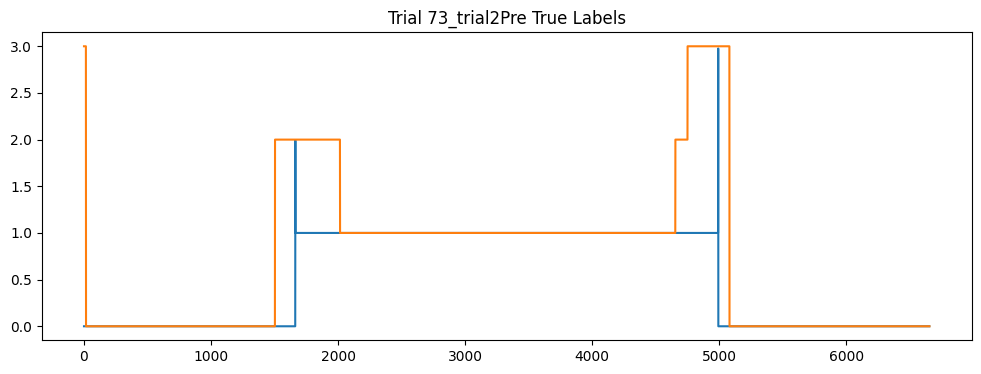

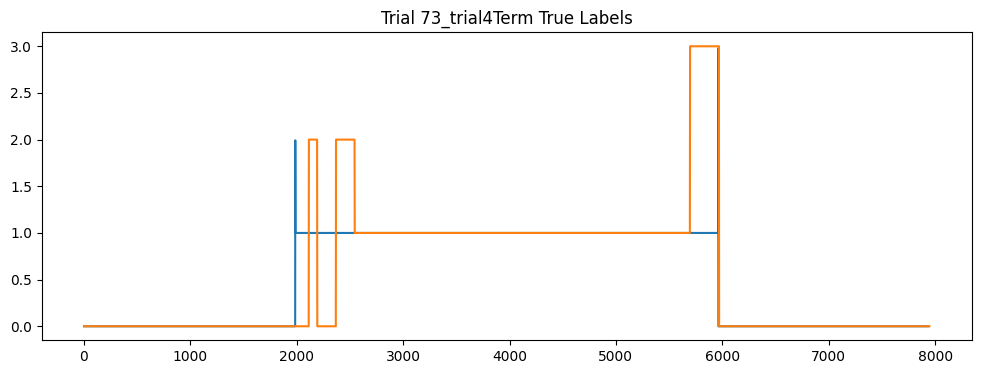

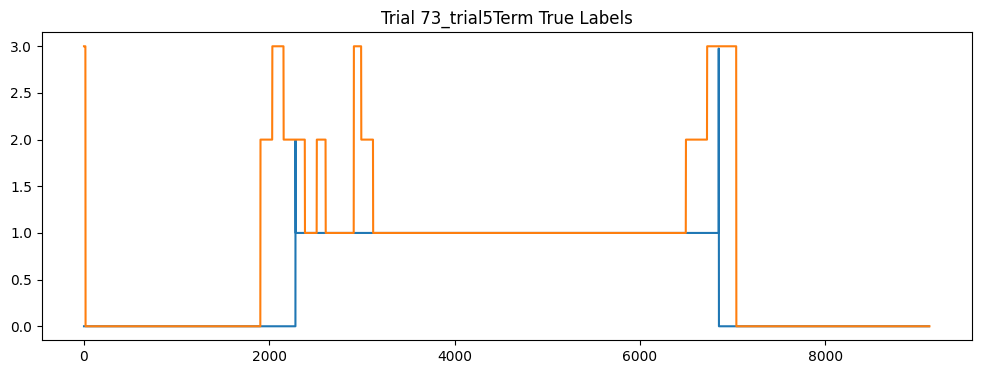

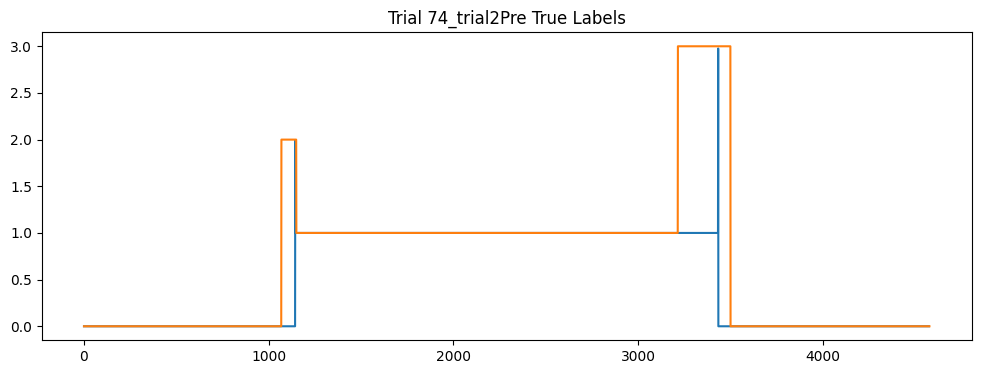

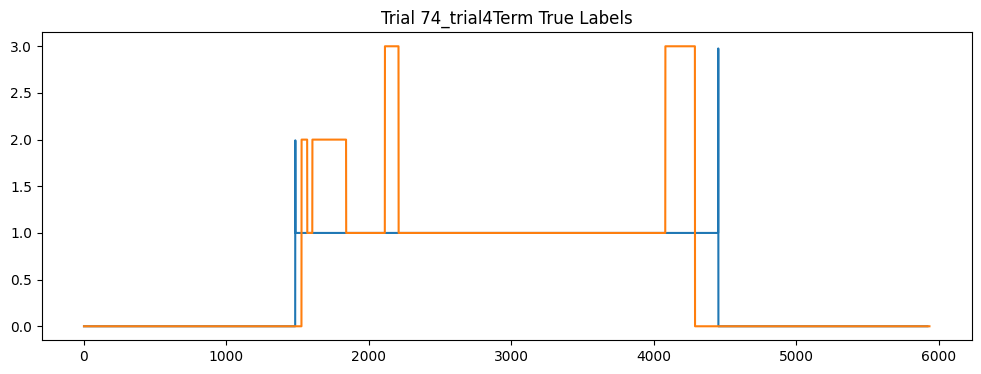

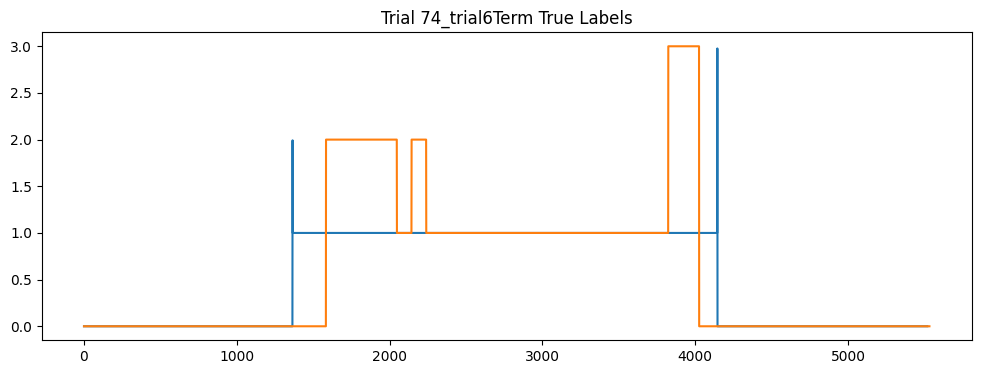

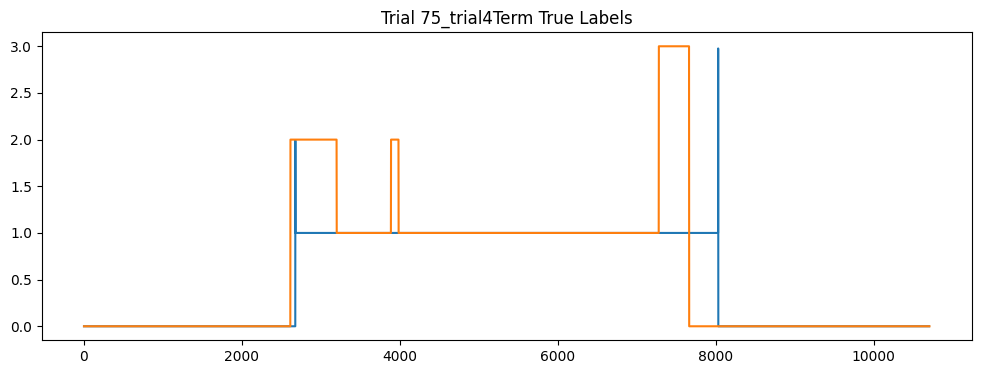

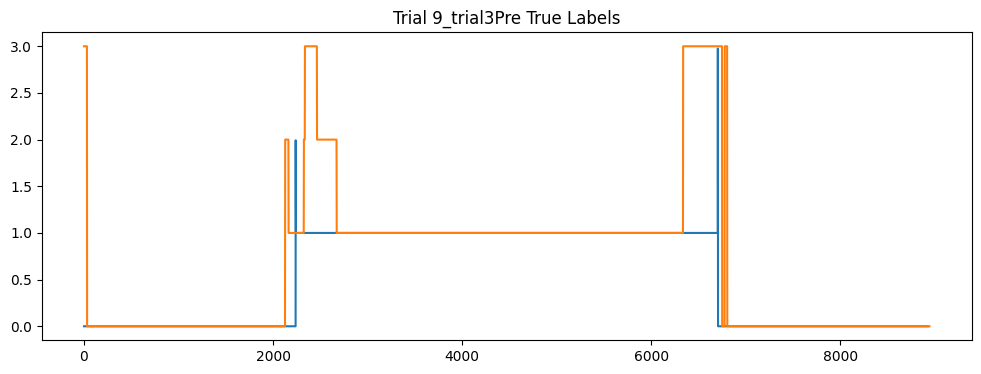

In [15]:
# OVERLAPPING TX=128, SRIDE=32 OR 1
import json
import numpy as np
import matplotlib.pyplot as plt

# Load trial length map

Y_test = np.load('AWS_Run\\OverlappingDataWithDiffStrides\\Y_test.npy')
trialIDs_test = np.load('AWS_Run\\OverlappingDataWithDiffStrides\\trial_ids_test.npy', allow_pickle=True)
predictions = np.load('AWS_Run\\OverlappingDataWithDiffStrides\\predictions_arch2.npz', allow_pickle=True)

predClassesPerWindow = predictions["pred_classes"]
predConfPerWindow = predictions["pred_confidences"]
Y_windowLabels_test = predictions["Y_windowLabels_test"]
precentageWindowMatch = np.mean(predClassesPerWindow == Y_windowLabels_test) * 100
print(f"Window-level accuracy: {precentageWindowMatch:.2f}%")

allLabelPred = []
allDistStart = []
allDistStop = []
percentageMatchSum = 0
count = 0
lengths = []
# Loop through each trial              
for trial in np.unique(trialIDs_test):
    data = np.load(f'AWS_Run\\OverlappingDataWithDiffStrides\\trialProbs_arch2/trial_{trial}.npz')
    avgProbs = data["avgProbs"]      # (L, 3): predicted probs per timestep
    counts = data["counts"]          # (L,)
    avgTrue = data["avgTrue"]        # could be (L,) or (L, 3)
    countsTrue = data["countsTrue"]  # (L,)
    predClassesPerWindow = data["predClassesPerWindow"]
    predConfPerWindow = data["predConfPerWindow"]
    Y_windowLabels_test = data["Y_windowLabels_test"]
    L = int(data["length"])
    
    lengths.append(L)
    
    predClasses = np.argmax(avgProbs, axis=1)
    trueClasses = avgTrue  
    
    trueClasses = fill_nans_with_next(trueClasses)
    
    # indices = np.arange(len(trueClasses))
    # goodIdxs = ~np.isnan(trueClasses)
    # trueClasses[~goodIdxs] = np.interp(indices[~goodIdxs], indices[goodIdxs], trueClasses[goodIdxs])

    # print(avgProbs.shape)
    maxProbIdx = np.argmax(avgProbs, axis=0)

    # Sanity checks
    assert predClasses.shape == (L,)
    assert trueClasses.shape == (L,)
    
    # Compare percentages timesteps in a trial that predClass matches trueClass (BEFORE Post-processing)
    percentageMatch = np.mean(predClasses == trueClasses) * 100
    percentageMatchSum = percentageMatchSum + percentageMatch
    count = count + 1
    

    # trueClasses = np.rint(trueClasses)
    plt.figure(figsize=(12,4))
    plt.plot(trueClasses, label='True')
    plt.title(f'Trial {trial} True Labels')
    plt.plot(predClasses, label='Predicted')#, alpha=0.7)
    # trueStartMask = np.where(trueClasses == 2)[0]
    # trueStopMask  = np.where(trueClasses == 3)[0]   
    
    

percentageMatchAvg = percentageMatchSum / count
print(f"Average Binary Timestep Accuracy Before Post-Processing: {percentageMatchAvg:.2f}%")


In [17]:
# OVERLAPPING TX=128, SRIDE=32 OR 1
import json
import numpy as np
import matplotlib.pyplot as plt

# Load trial length map

Y_test = np.load('NoOverlap\\Y_test.npy')
trialIDs_test = np.load('NoOverlap\\trial_ids_test.npy', allow_pickle=True)
predictions = np.load('NoOverlap\\predictions_arch1.npz', allow_pickle=True)

predClassesPerWindow = predictions["pred_classes"]
predConfPerWindow = predictions["pred_confidences"]
Y_windowLabels_test = predictions["Y_windowLabels_test"]
precentageWindowMatch = np.mean(predClassesPerWindow == Y_windowLabels_test) * 100
print(f"Window-level accuracy: {precentageWindowMatch:.2f}%")

allLabelPred = []
allDistStart = []
allDistStop = []
percentageMatchSum = 0
count = 0
lengths = []
# Loop through each trial              
for trial in np.unique(trialIDs_test):
    data = np.load(f'NoOverlap\\trialProbs_arch1/trial_{trial}.npz')
    avgProbs = data["avgProbs"]      # (L, 3): predicted probs per timestep
    counts = data["counts"]          # (L,)
    avgTrue = data["avgTrue"]        # could be (L,) or (L, 3)
    countsTrue = data["countsTrue"]  # (L,)
    predClassesPerWindow = data["predClassesPerWindow"]
    predConfPerWindow = data["predConfPerWindow"]
    Y_windowLabels_test = data["Y_windowLabels_test"]
    L = int(data["length"])
    
    lengths.append(L)
    
    predClasses = np.argmax(avgProbs, axis=1)
    trueClasses = avgTrue  
    
    trueClasses = fill_nans_with_next(trueClasses)
    
    # indices = np.arange(len(trueClasses))
    # goodIdxs = ~np.isnan(trueClasses)
    # trueClasses[~goodIdxs] = np.interp(indices[~goodIdxs], indices[goodIdxs], trueClasses[goodIdxs])

    # print(avgProbs.shape)
    maxProbIdx = np.argmax(avgProbs, axis=0)

    # Sanity checks
    assert predClasses.shape == (L,)
    assert trueClasses.shape == (L,)
    
    # Compare percentages timesteps in a trial that predClass matches trueClass (BEFORE Post-processing)
    percentageMatch = np.mean(predClasses == trueClasses) * 100
    percentageMatchSum = percentageMatchSum + percentageMatch
    count = count + 1
    

    # trueClasses = np.rint(trueClasses)
    # plt.figure(figsize=(12,4))
    # plt.plot(trueClasses, label='True')
    # plt.title(f'Trial {trial} True Labels')
    # plt.plot(predClasses, label='Predicted')#, alpha=0.7)
    # trueStartMask = np.where(trueClasses == 2)[0]
    # trueStopMask  = np.where(trueClasses == 3)[0]   
    
    

percentageMatchAvg = percentageMatchSum / count
print(f"Average Binary Timestep Accuracy Before Post-Processing: {percentageMatchAvg:.2f}%")


Window-level accuracy: 89.61%
Average Binary Timestep Accuracy Before Post-Processing: 92.56%


In [ ]:
# OVERLAPPING TX=128, SRIDE=32 OR 1
import json
import numpy as np
import matplotlib.pyplot as plt

# Load trial length map

Y_test = np.load('NoOverlap\\Y_test.npy')
trialIDs_test = np.load('NoOverlap\\trial_ids_test.npy', allow_pickle=True)
predictions = np.load('NoOverlap\\predictions_arch1Weights.npz', allow_pickle=True)

predClassesPerWindow = predictions["pred_classes"]
predConfPerWindow = predictions["pred_confidences"]
Y_windowLabels_test = predictions["Y_windowLabels_test"]
precentageWindowMatch = np.mean(predClassesPerWindow == Y_windowLabels_test) * 100
print(f"Window-level accuracy: {precentageWindowMatch:.2f}%")

allLabelPred = []
allDistStart = []
allDistStop = []
percentageMatchSum = 0
count = 0
lengths = []
# Loop through each trial              
for trial in np.unique(trialIDs_test):
    data = np.load(f'NoOverlap\\trialProbs_arch1Weights/trial_{trial}.npz')
    avgProbs = data["avgProbs"]      # (L, 3): predicted probs per timestep
    counts = data["counts"]          # (L,)
    avgTrue = data["avgTrue"]        # could be (L,) or (L, 3)
    countsTrue = data["countsTrue"]  # (L,)
    predClassesPerWindow = data["predClassesPerWindow"]
    predConfPerWindow = data["predConfPerWindow"]
    Y_windowLabels_test = data["Y_windowLabels_test"]
    L = int(data["length"])
    
    lengths.append(L)
    
    predClasses = np.argmax(avgProbs, axis=1)
    trueClasses = avgTrue  
    
    trueClasses = fill_nans_with_next(trueClasses)
    
    # indices = np.arange(len(trueClasses))
    # goodIdxs = ~np.isnan(trueClasses)
    # trueClasses[~goodIdxs] = np.interp(indices[~goodIdxs], indices[goodIdxs], trueClasses[goodIdxs])

    # print(avgProbs.shape)
    maxProbIdx = np.argmax(avgProbs, axis=0)

    # Sanity checks
    assert predClasses.shape == (L,)
    assert trueClasses.shape == (L,)
    
    # Compare percentages timesteps in a trial that predClass matches trueClass (BEFORE Post-processing)
    percentageMatch = np.mean(predClasses == trueClasses) * 100
    percentageMatchSum = percentageMatchSum + percentageMatch
    count = count + 1
    
    

percentageMatchAvg = percentageMatchSum / count
print(f"Average Binary Timestep Accuracy Before Post-Processing: {percentageMatchAvg:.2f}%")




Window-level accuracy: 88.19%
Average Binary Timestep Accuracy Before Post-Processing: 91.23%


In [20]:
# OVERLAPPING TX=128, SRIDE=32 OR 1
import json
import numpy as np
import matplotlib.pyplot as plt

# Load trial length map

Y_test = np.load('NoOverlap\\Y_test.npy')
trialIDs_test = np.load('NoOverlap\\trial_ids_test.npy', allow_pickle=True)
predictions = np.load('NoOverlap\\predictions_arch2.npz', allow_pickle=True)

predClassesPerWindow = predictions["pred_classes"]
predConfPerWindow = predictions["pred_confidences"]
Y_windowLabels_test = predictions["Y_windowLabels_test"]
precentageWindowMatch = np.mean(predClassesPerWindow == Y_windowLabels_test) * 100
print(f"Window-level accuracy: {precentageWindowMatch:.2f}%")

allLabelPred = []
allDistStart = []
allDistStop = []
percentageMatchSum = 0
count = 0
lengths = []
# Loop through each trial              
for trial in np.unique(trialIDs_test):
    data = np.load(f'NoOverlap\\trialProbs_arch2/trial_{trial}.npz')
    avgProbs = data["avgProbs"]      # (L, 3): predicted probs per timestep
    counts = data["counts"]          # (L,)
    avgTrue = data["avgTrue"]        # could be (L,) or (L, 3)
    countsTrue = data["countsTrue"]  # (L,)
    predClassesPerWindow = data["predClassesPerWindow"]
    predConfPerWindow = data["predConfPerWindow"]
    Y_windowLabels_test = data["Y_windowLabels_test"]
    L = int(data["length"])
    
    lengths.append(L)
    
    predClasses = np.argmax(avgProbs, axis=1)
    trueClasses = avgTrue  
    
    trueClasses = fill_nans_with_next(trueClasses)
    
    # indices = np.arange(len(trueClasses))
    # goodIdxs = ~np.isnan(trueClasses)
    # trueClasses[~goodIdxs] = np.interp(indices[~goodIdxs], indices[goodIdxs], trueClasses[goodIdxs])

    # print(avgProbs.shape)
    maxProbIdx = np.argmax(avgProbs, axis=0)

    # Sanity checks
    assert predClasses.shape == (L,)
    assert trueClasses.shape == (L,)
    
    # Compare percentages timesteps in a trial that predClass matches trueClass (BEFORE Post-processing)
    percentageMatch = np.mean(predClasses == trueClasses) * 100
    percentageMatchSum = percentageMatchSum + percentageMatch
    count = count + 1
    
    

percentageMatchAvg = percentageMatchSum / count
print(f"Average Binary Timestep Accuracy Before Post-Processing: {percentageMatchAvg:.2f}%")


Window-level accuracy: 88.01%
Average Binary Timestep Accuracy Before Post-Processing: 91.63%


In [21]:
# OVERLAPPING TX=128, SRIDE=32 OR 1
import json
import numpy as np
import matplotlib.pyplot as plt

# Load trial length map

Y_test = np.load('NoOverlap\\Y_test.npy')
trialIDs_test = np.load('NoOverlap\\trial_ids_test.npy', allow_pickle=True)
predictions = np.load('NoOverlap\\predictions_arch2Weights.npz', allow_pickle=True)

predClassesPerWindow = predictions["pred_classes"]
predConfPerWindow = predictions["pred_confidences"]
Y_windowLabels_test = predictions["Y_windowLabels_test"]
precentageWindowMatch = np.mean(predClassesPerWindow == Y_windowLabels_test) * 100
print(f"Window-level accuracy: {precentageWindowMatch:.2f}%")

allLabelPred = []
allDistStart = []
allDistStop = []
percentageMatchSum = 0
count = 0
lengths = []
# Loop through each trial              
for trial in np.unique(trialIDs_test):
    data = np.load(f'NoOverlap\\trialProbs_arch2Weights/trial_{trial}.npz')
    avgProbs = data["avgProbs"]      # (L, 3): predicted probs per timestep
    counts = data["counts"]          # (L,)
    avgTrue = data["avgTrue"]        # could be (L,) or (L, 3)
    countsTrue = data["countsTrue"]  # (L,)
    predClassesPerWindow = data["predClassesPerWindow"]
    predConfPerWindow = data["predConfPerWindow"]
    Y_windowLabels_test = data["Y_windowLabels_test"]
    L = int(data["length"])
    
    lengths.append(L)
    
    predClasses = np.argmax(avgProbs, axis=1)
    trueClasses = avgTrue  
    
    trueClasses = fill_nans_with_next(trueClasses)
    
    # indices = np.arange(len(trueClasses))
    # goodIdxs = ~np.isnan(trueClasses)
    # trueClasses[~goodIdxs] = np.interp(indices[~goodIdxs], indices[goodIdxs], trueClasses[goodIdxs])

    # print(avgProbs.shape)
    maxProbIdx = np.argmax(avgProbs, axis=0)

    # Sanity checks
    assert predClasses.shape == (L,)
    assert trueClasses.shape == (L,)
    
    # Compare percentages timesteps in a trial that predClass matches trueClass (BEFORE Post-processing)
    percentageMatch = np.mean(predClasses == trueClasses) * 100
    percentageMatchSum = percentageMatchSum + percentageMatch
    count = count + 1
    
   
    

percentageMatchAvg = percentageMatchSum / count
print(f"Average Binary Timestep Accuracy Before Post-Processing: {percentageMatchAvg:.2f}%")
# 


Window-level accuracy: 87.90%
Average Binary Timestep Accuracy Before Post-Processing: 91.28%


In [23]:
# OVERLAPPING TX=128, SRIDE=32 OR 1
import json
import numpy as np
import matplotlib.pyplot as plt

# Load trial length map

Y_test = np.load('NoOverlap_Val\\Y_test.npy')
trialIDs_test = np.load('NoOverlap_Val\\trial_ids_test.npy', allow_pickle=True)
predictions = np.load('NoOverlap_Val\\predictions_arch1ValWeights.npz', allow_pickle=True)

predClassesPerWindow = predictions["pred_classes"]
predConfPerWindow = predictions["pred_confidences"]
Y_windowLabels_test = predictions["Y_windowLabels_test"]
precentageWindowMatch = np.mean(predClassesPerWindow == Y_windowLabels_test) * 100
print(f"Window-level accuracy: {precentageWindowMatch:.2f}%")

allLabelPred = []
allDistStart = []
allDistStop = []
percentageMatchSum = 0
count = 0
lengths = []
# Loop through each trial              
for trial in np.unique(trialIDs_test):
    data = np.load(f'NoOverlap_Val\\trialProbs_arch1ValWeights/trial_{trial}.npz')
    avgProbs = data["avgProbs"]      # (L, 3): predicted probs per timestep
    counts = data["counts"]          # (L,)
    avgTrue = data["avgTrue"]        # could be (L,) or (L, 3)
    countsTrue = data["countsTrue"]  # (L,)
    predClassesPerWindow = data["predClassesPerWindow"]
    predConfPerWindow = data["predConfPerWindow"]
    Y_windowLabels_test = data["Y_windowLabels_test"]
    L = int(data["length"])
    
    lengths.append(L)
    
    predClasses = np.argmax(avgProbs, axis=1)
    trueClasses = avgTrue  
    
    trueClasses = fill_nans_with_next(trueClasses)
    
    # indices = np.arange(len(trueClasses))
    # goodIdxs = ~np.isnan(trueClasses)
    # trueClasses[~goodIdxs] = np.interp(indices[~goodIdxs], indices[goodIdxs], trueClasses[goodIdxs])

    # print(avgProbs.shape)
    maxProbIdx = np.argmax(avgProbs, axis=0)

    # Sanity checks
    assert predClasses.shape == (L,)
    assert trueClasses.shape == (L,)
    
    # Compare percentages timesteps in a trial that predClass matches trueClass (BEFORE Post-processing)
    percentageMatch = np.mean(predClasses == trueClasses) * 100
    percentageMatchSum = percentageMatchSum + percentageMatch
    count = count + 1
    
   
    

percentageMatchAvg = percentageMatchSum / count
print(f"Average Binary Timestep Accuracy Before Post-Processing: {percentageMatchAvg:.2f}%")
# 


Window-level accuracy: 74.85%
Average Binary Timestep Accuracy Before Post-Processing: 75.82%


Window-level accuracy: 79.98%


C:\Users\olivi\AppData\Local\Temp\ipykernel_33360\1165939201.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12,4))


Average Binary Timestep Accuracy Before Post-Processing: 82.36%


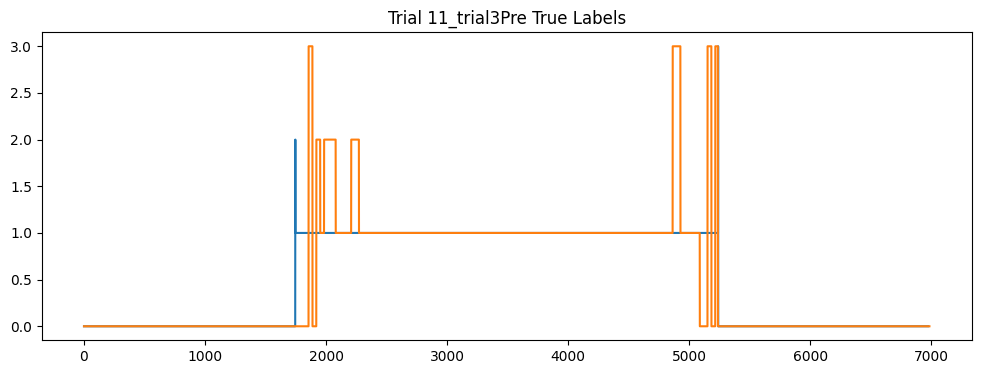

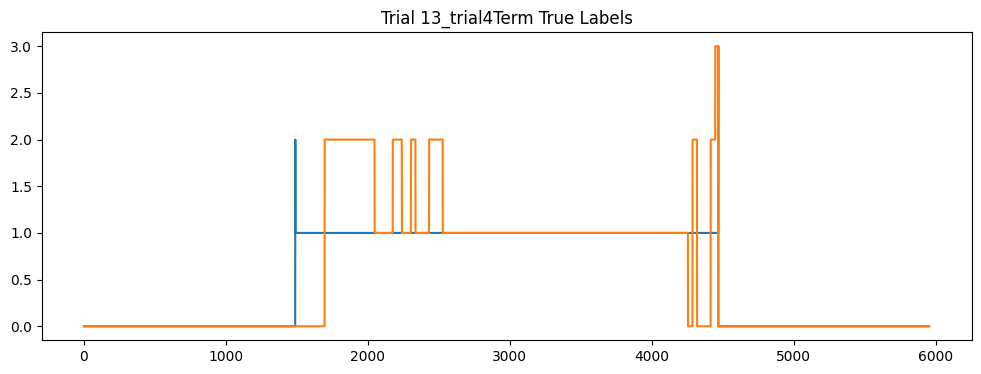

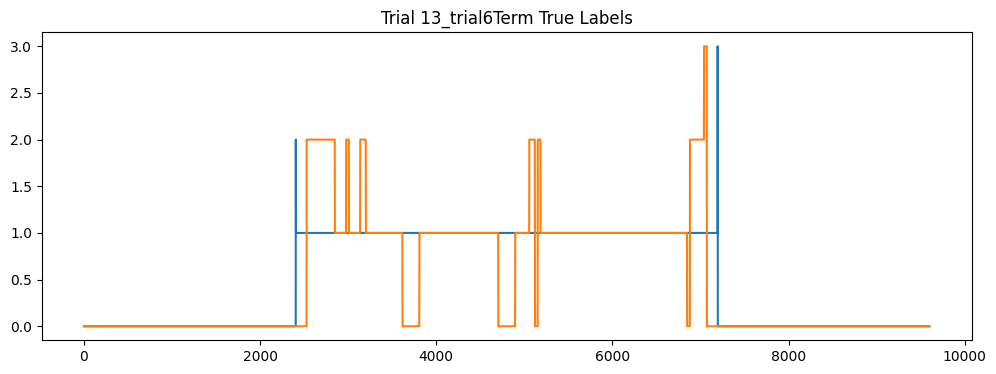

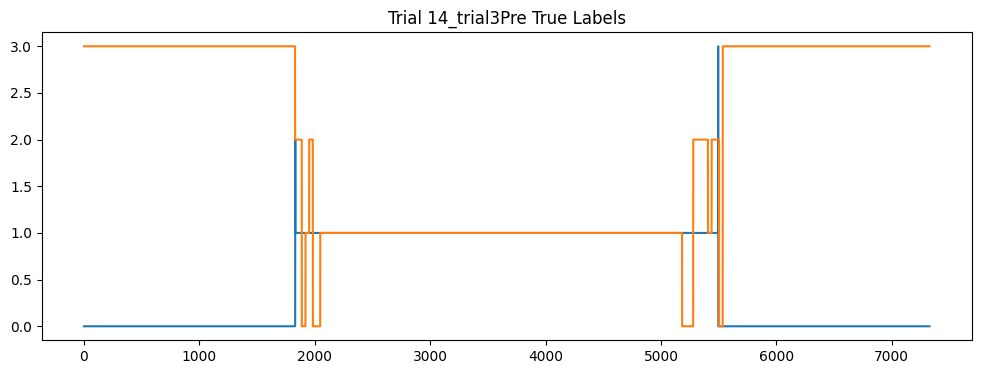

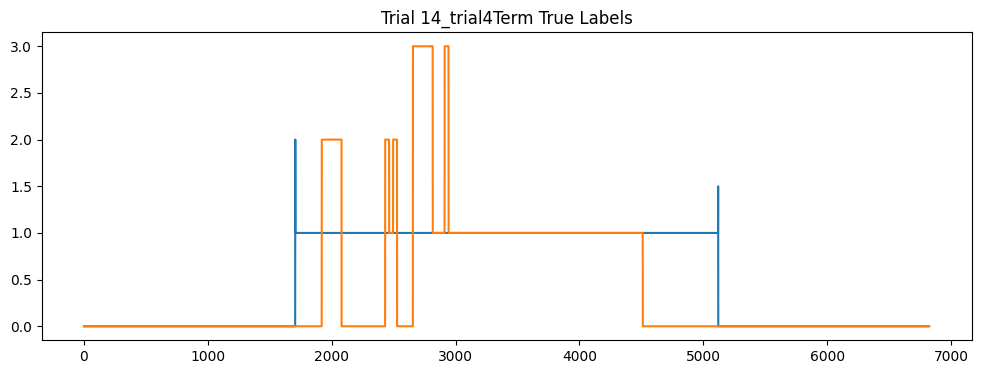

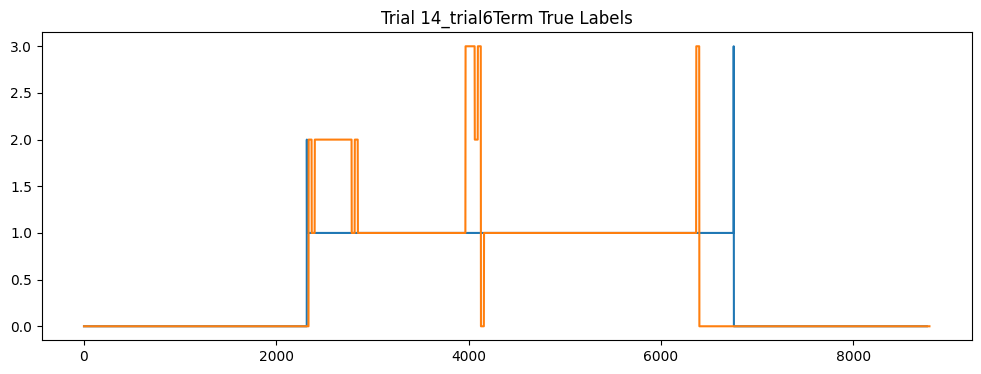

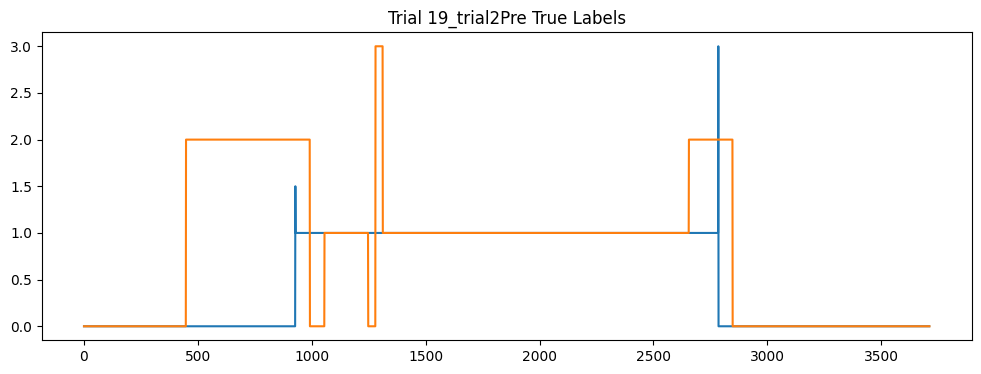

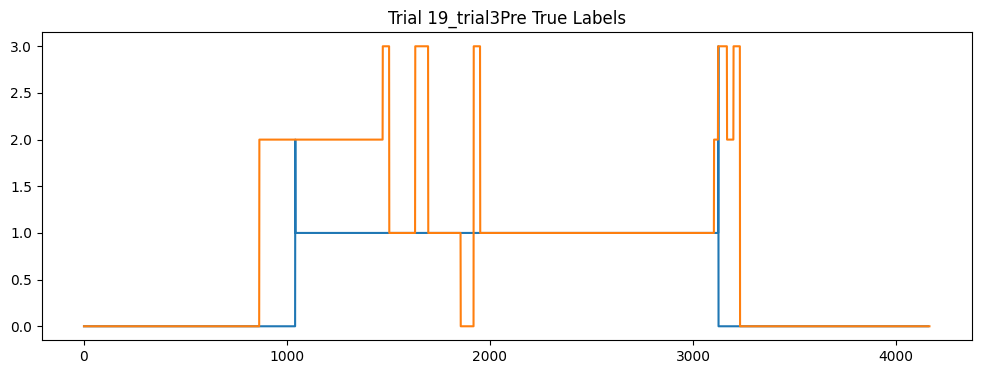

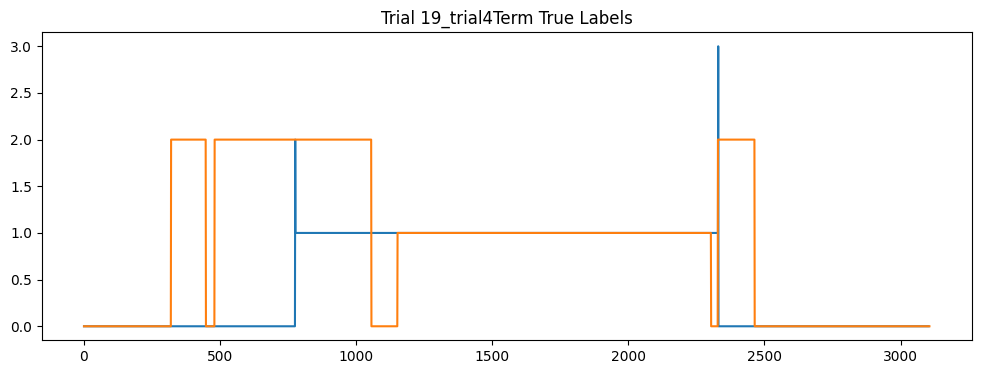

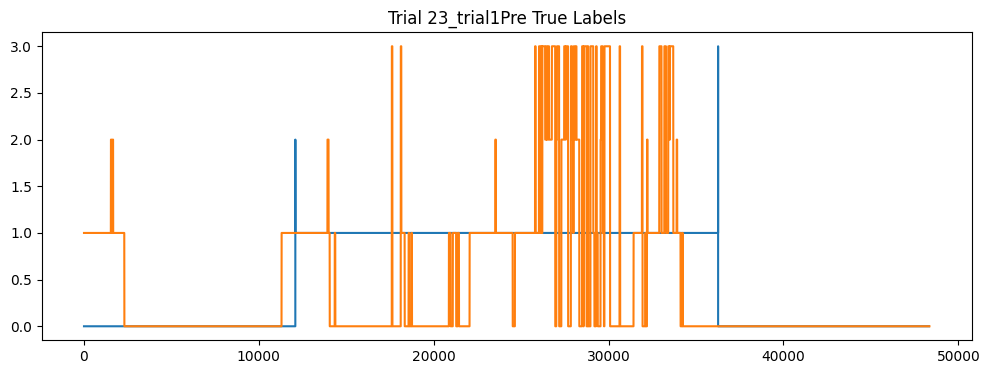

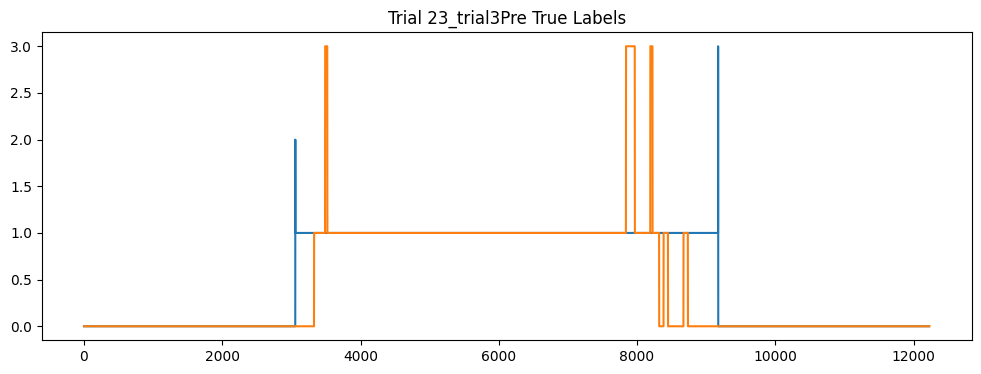

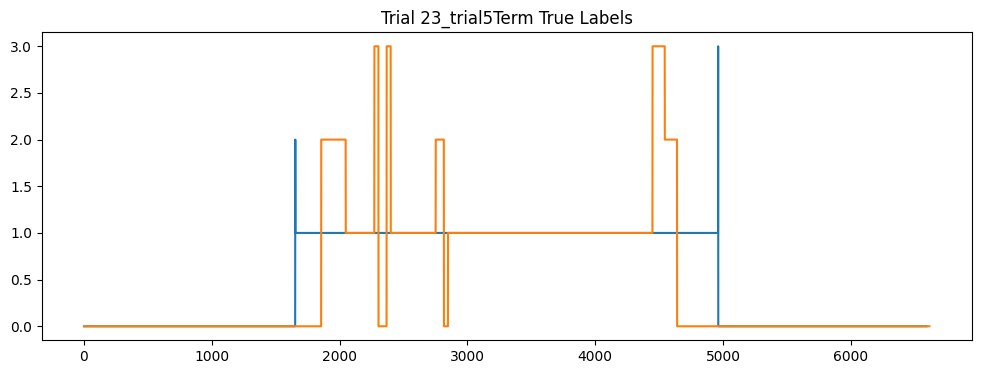

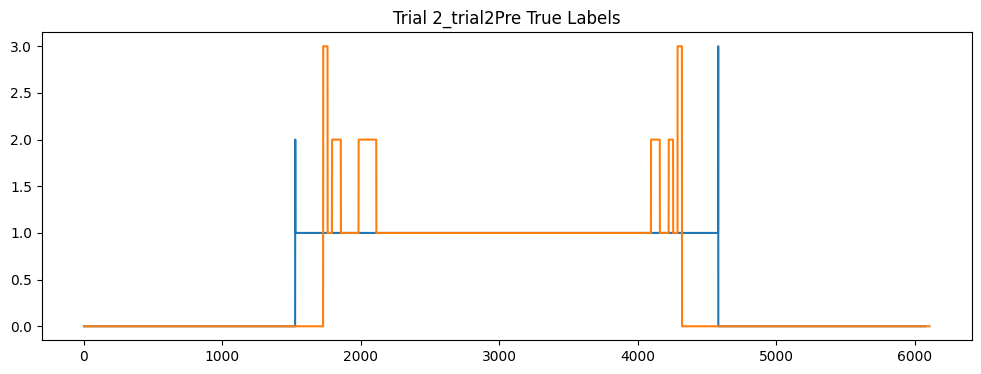

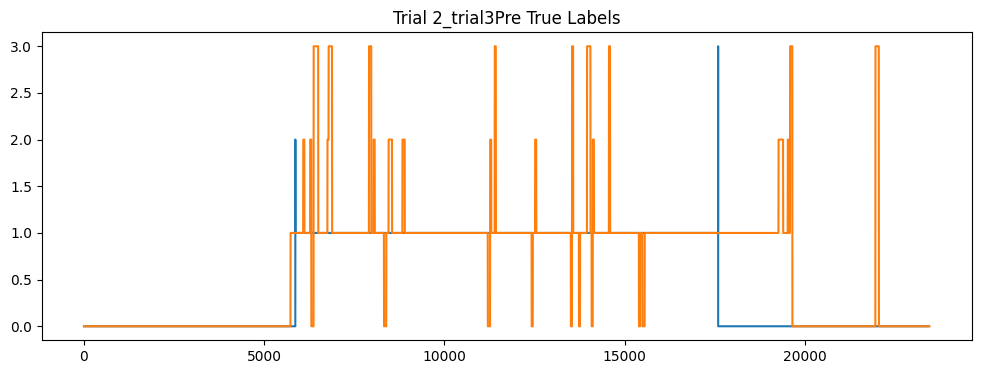

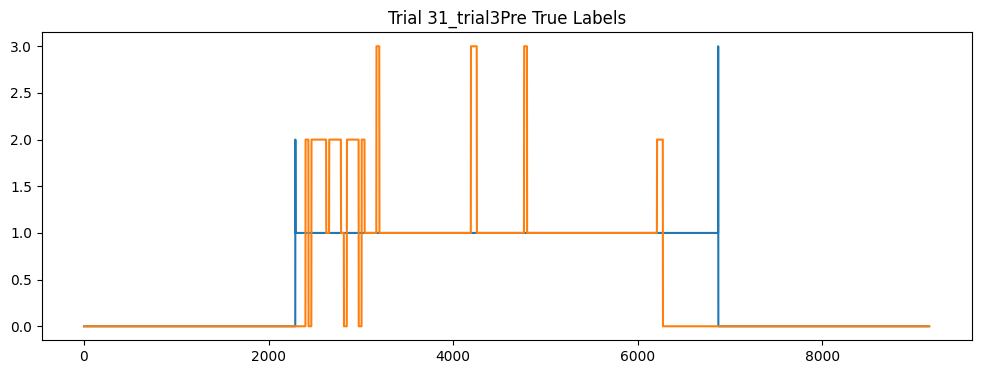

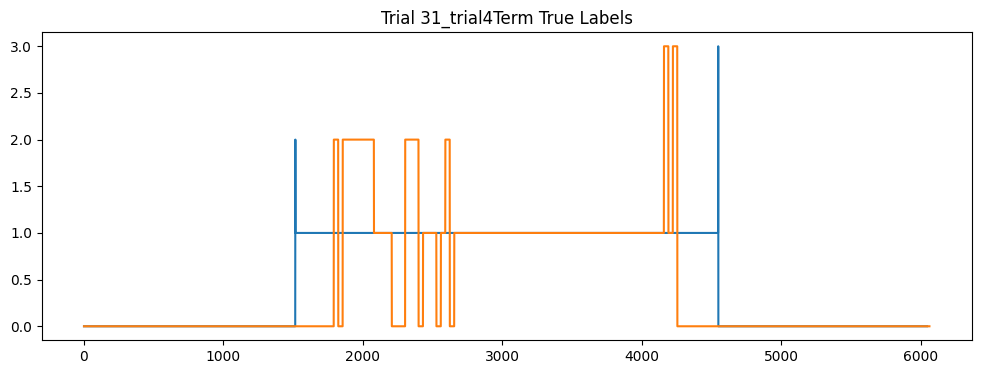

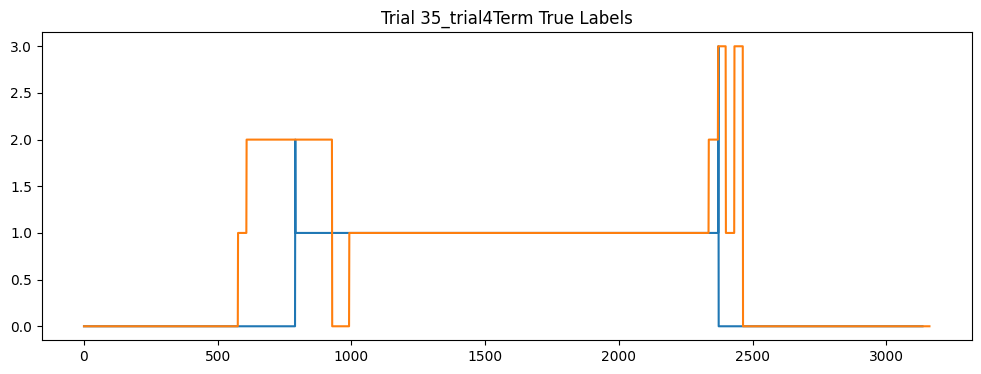

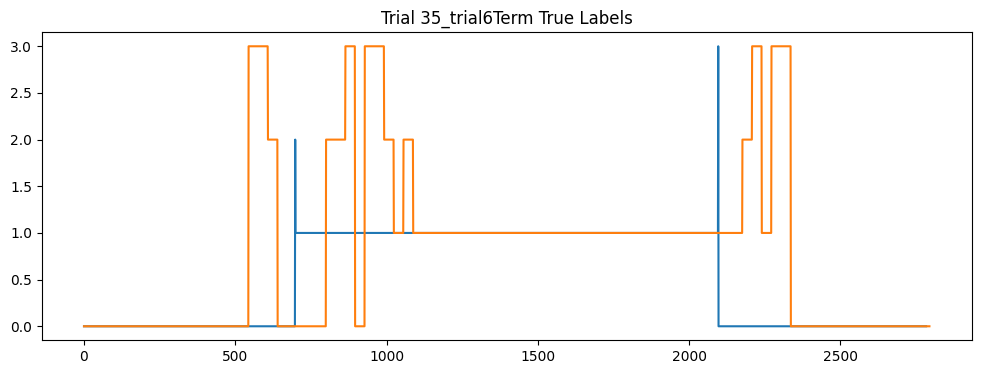

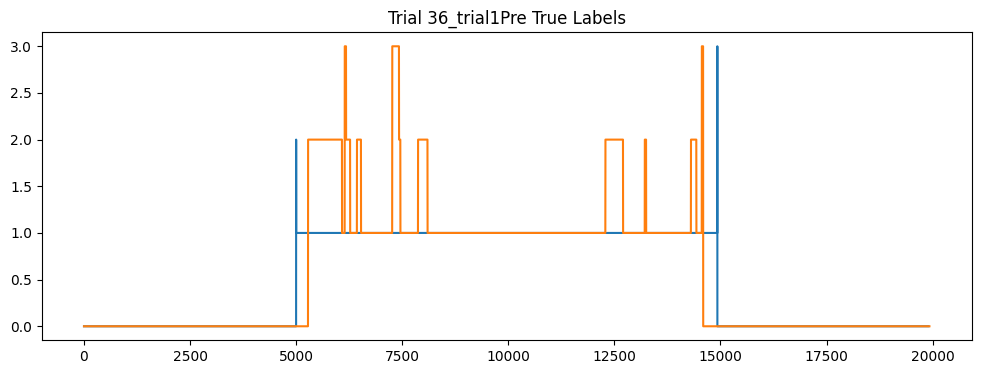

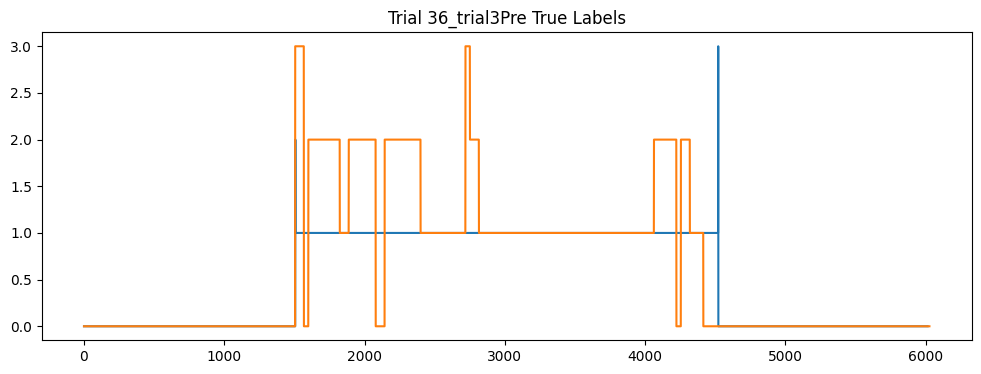

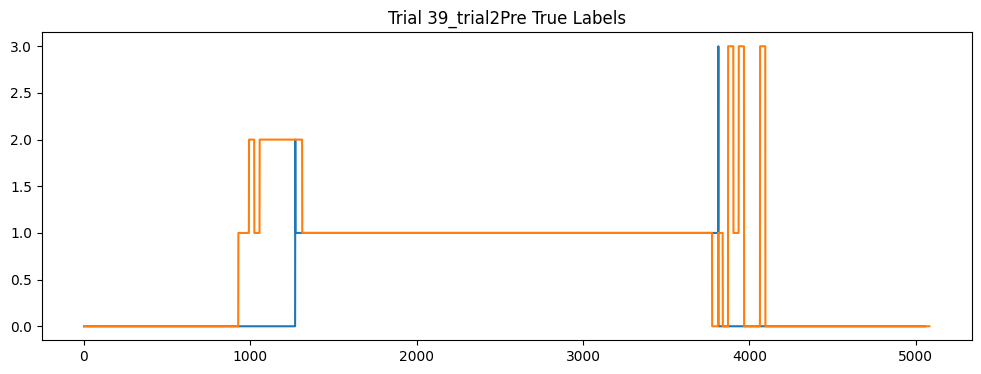

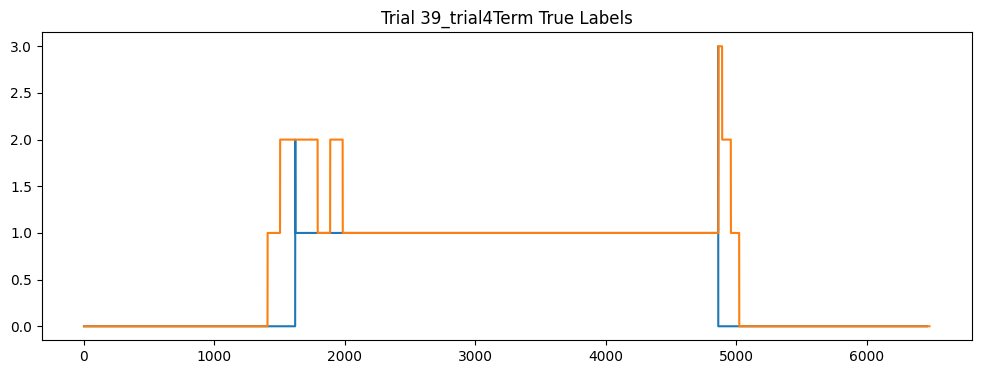

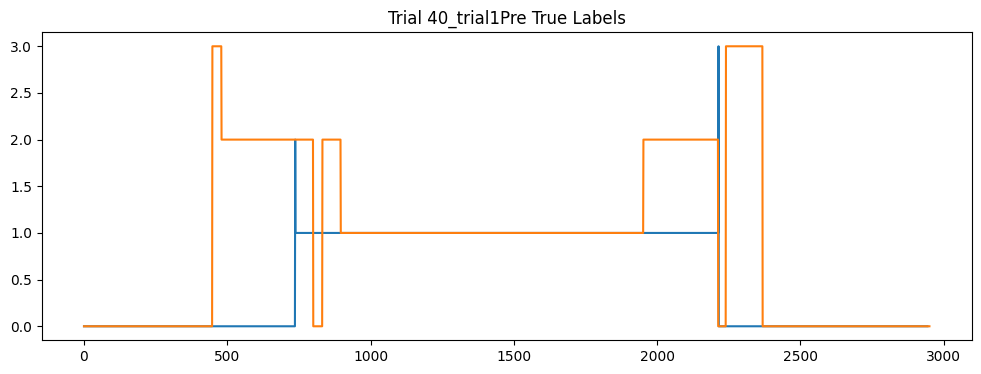

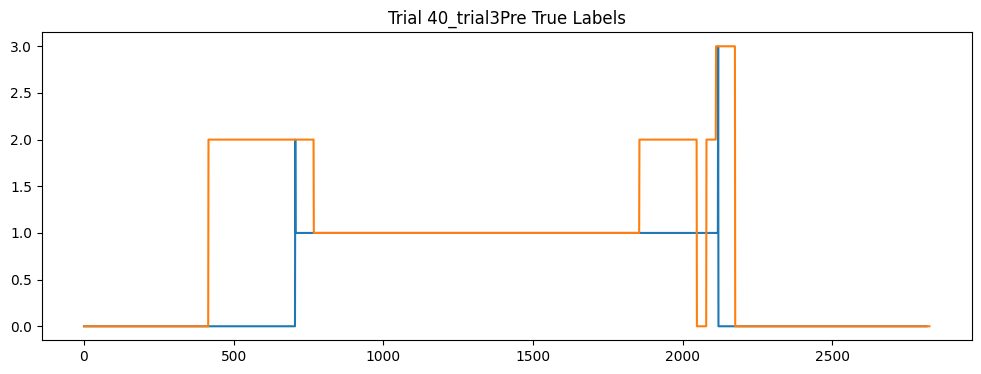

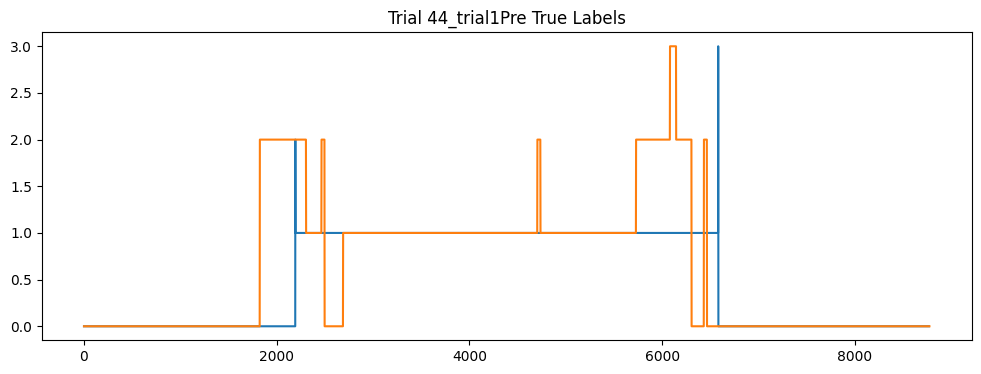

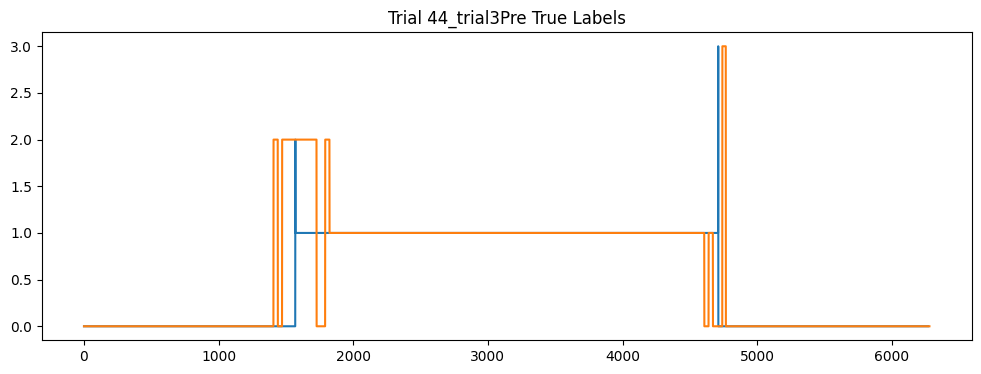

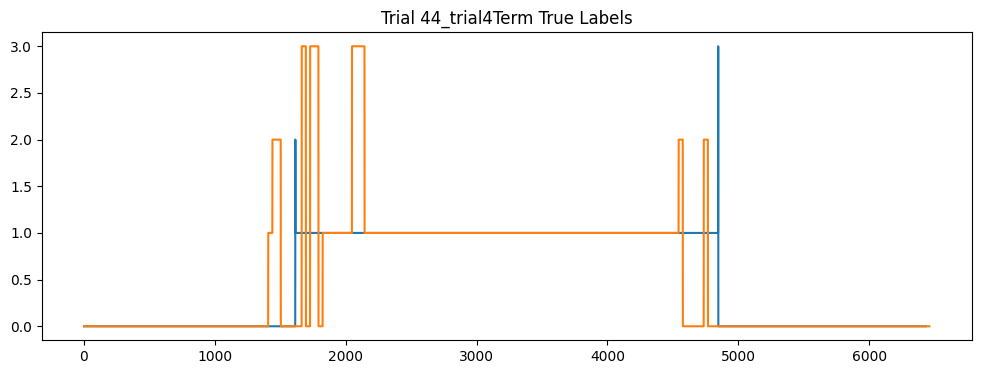

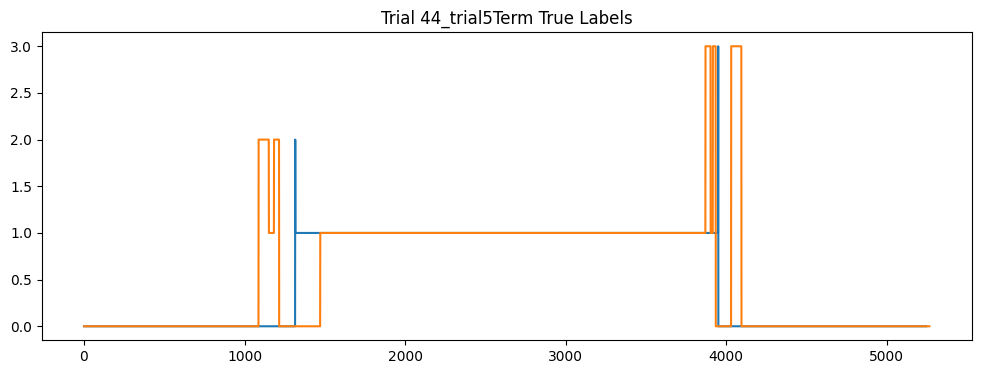

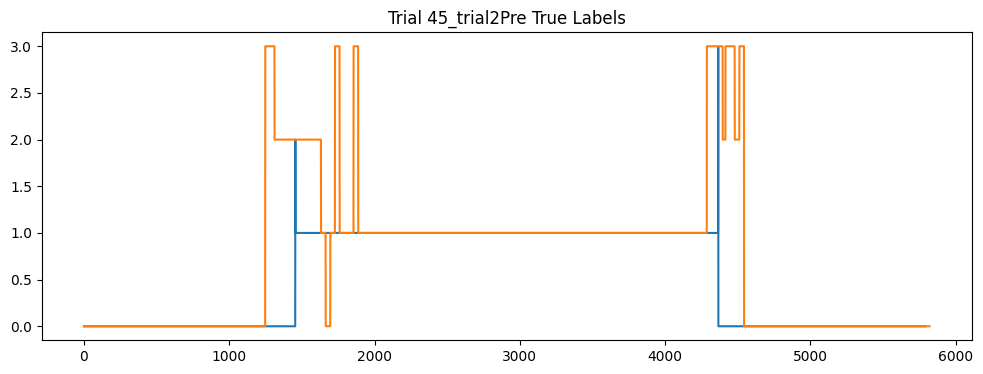

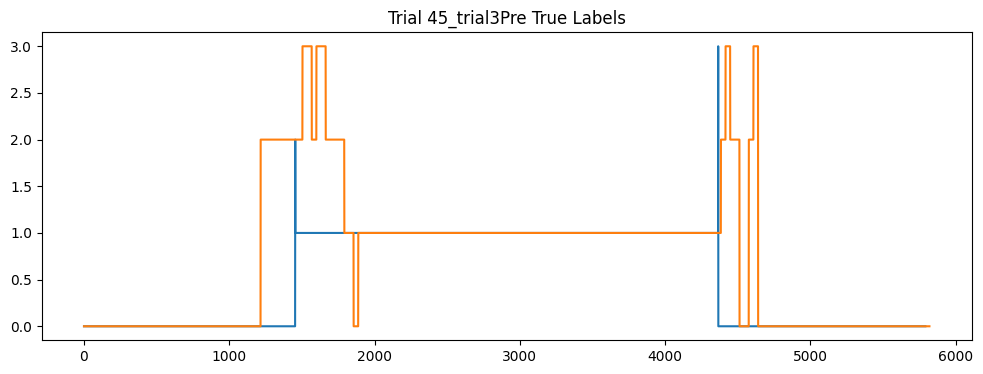

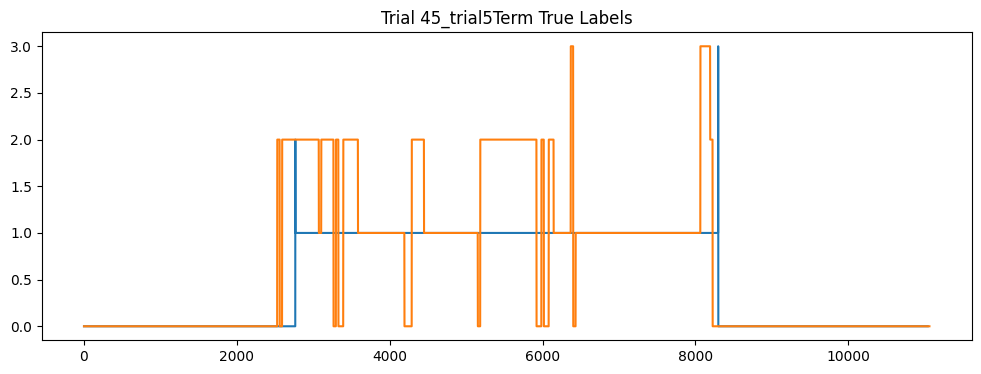

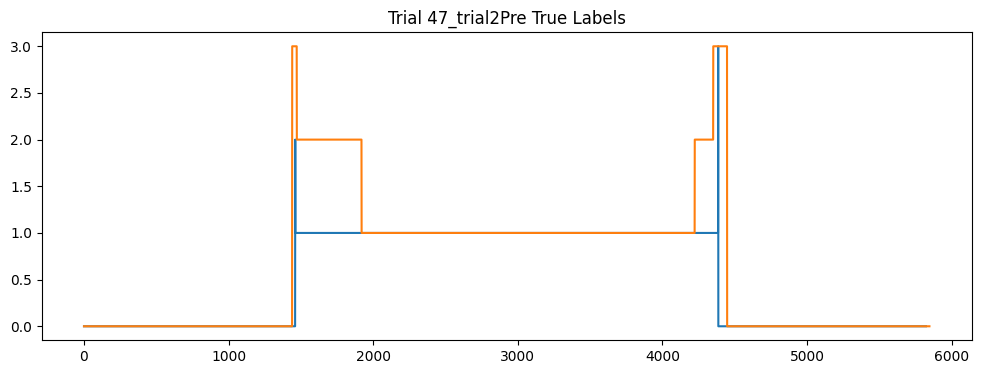

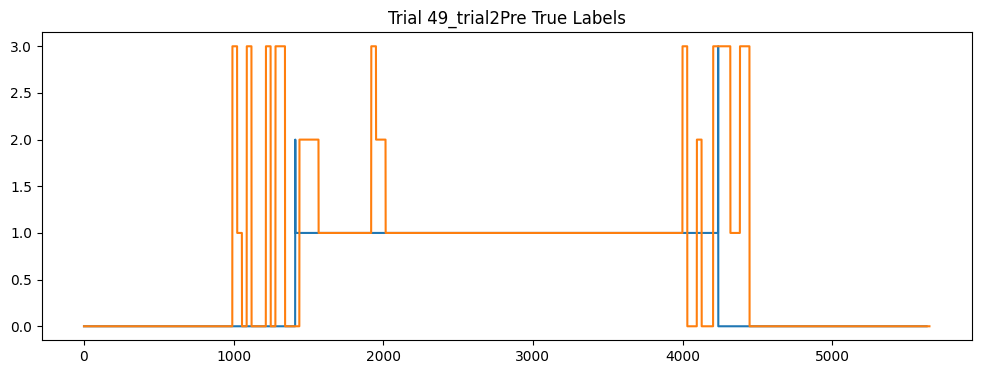

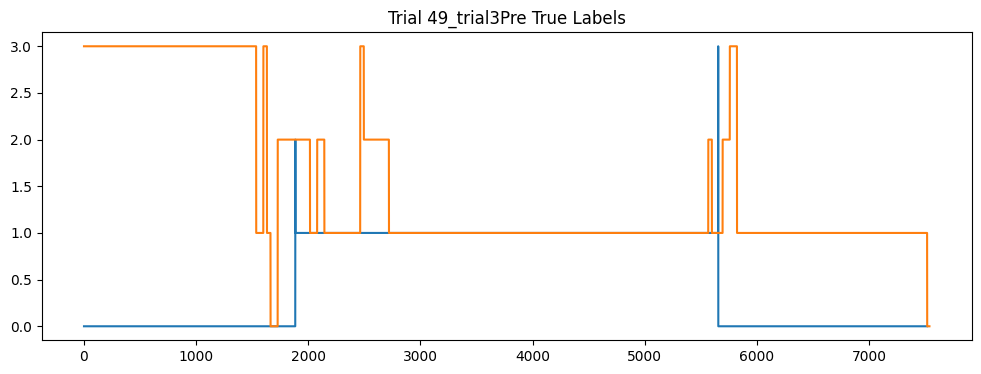

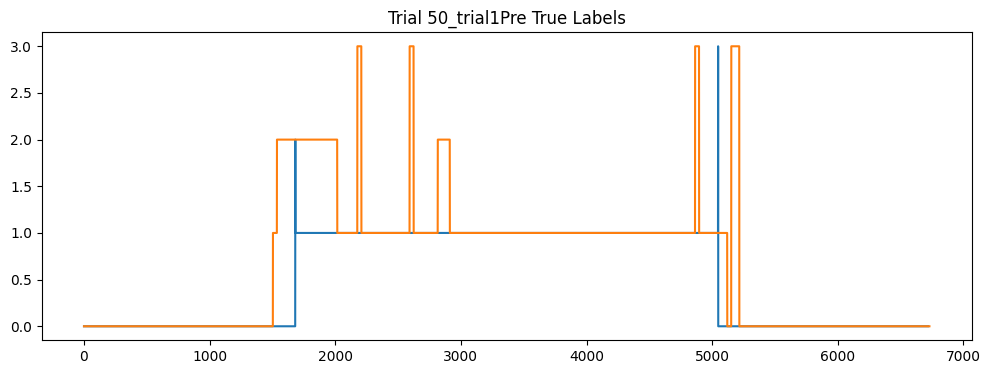

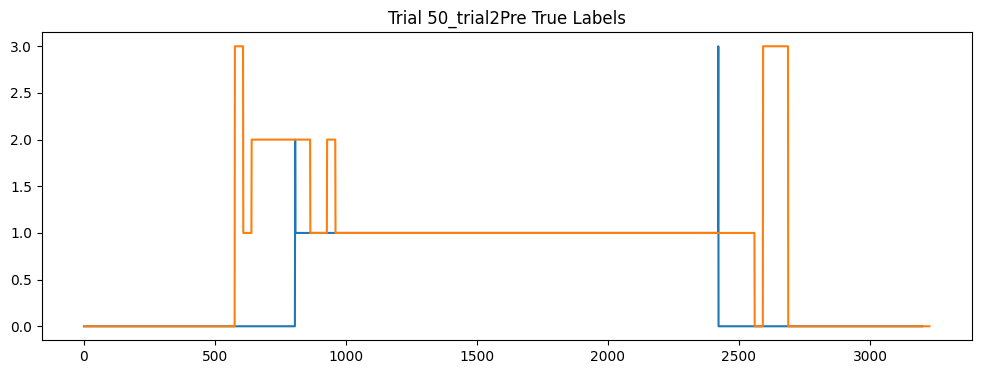

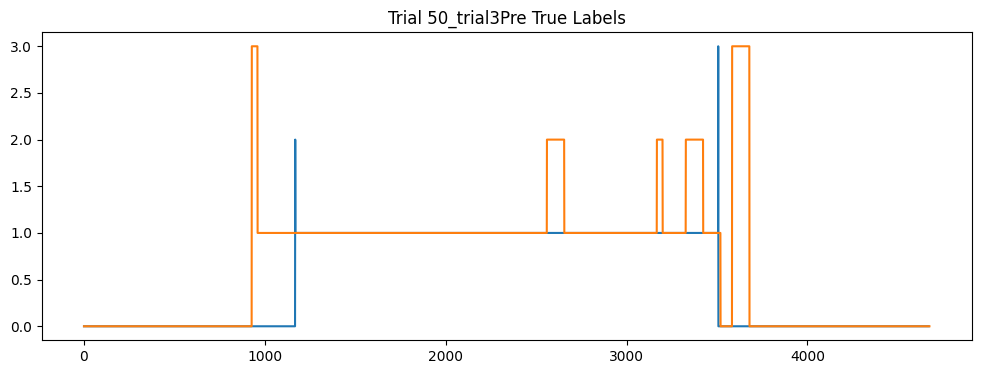

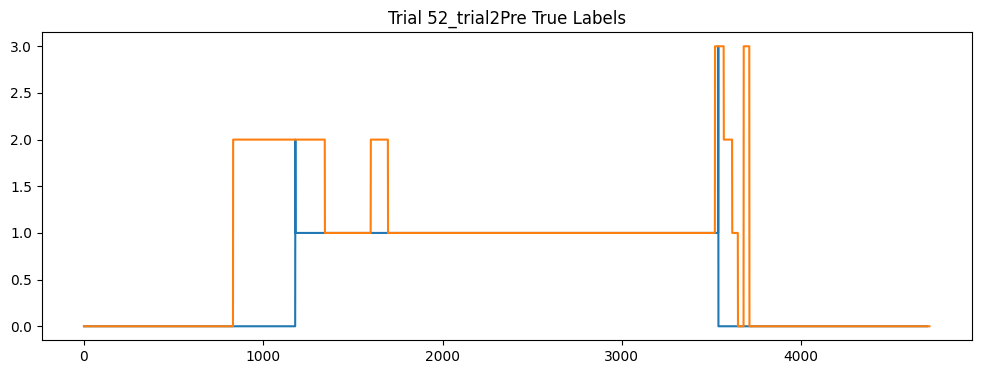

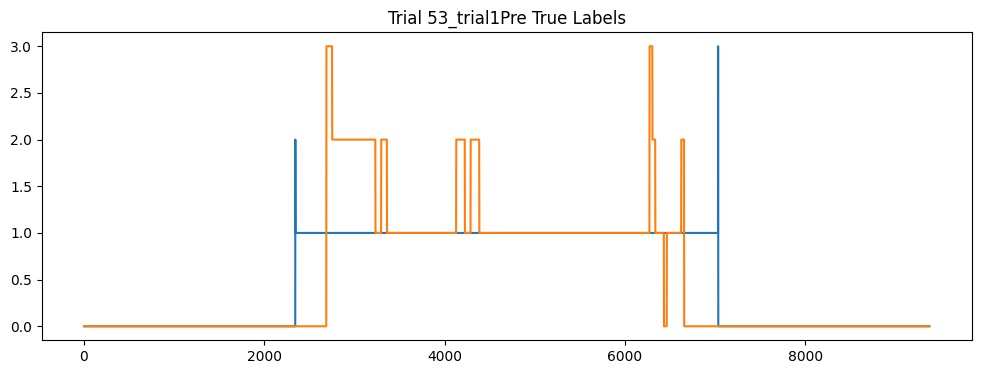

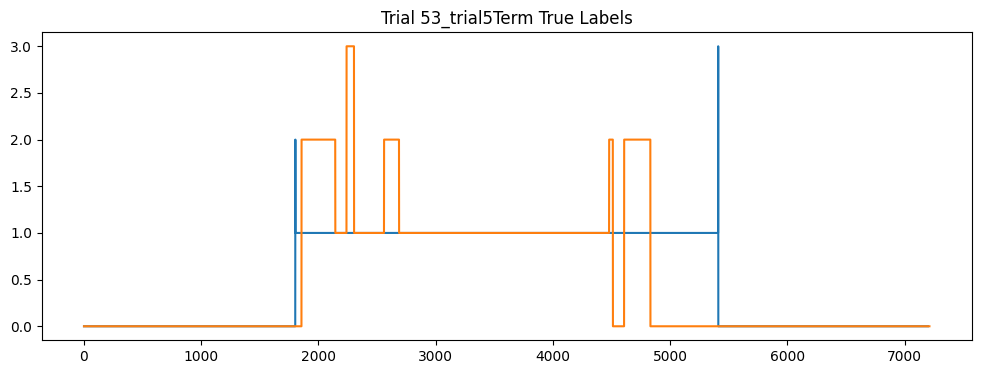

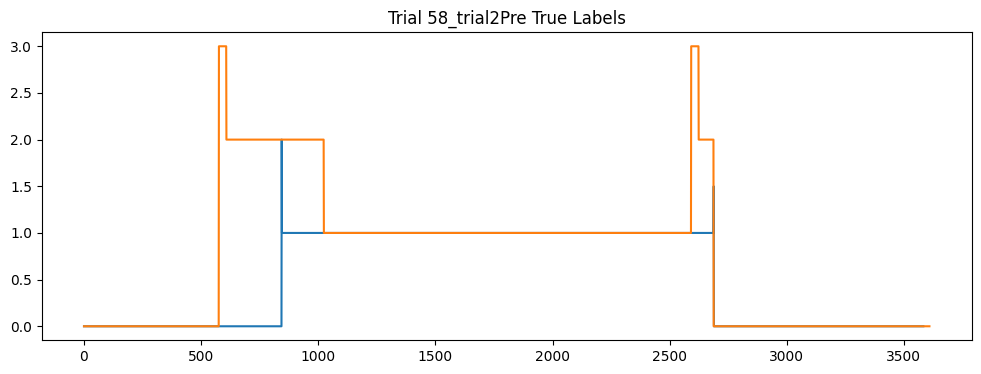

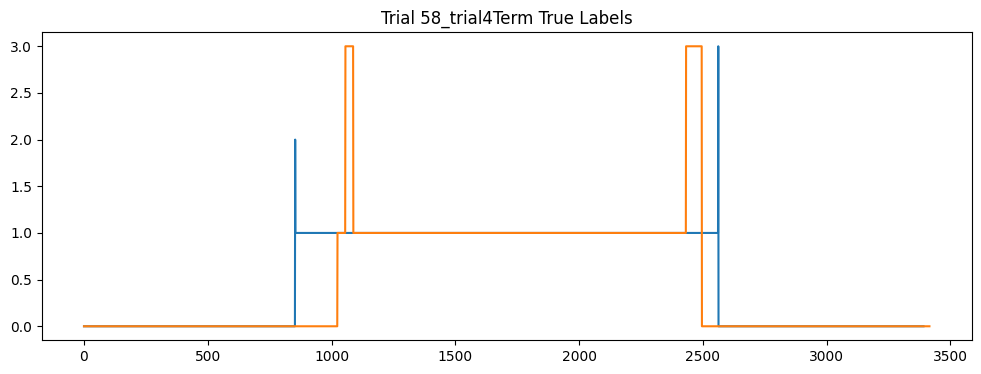

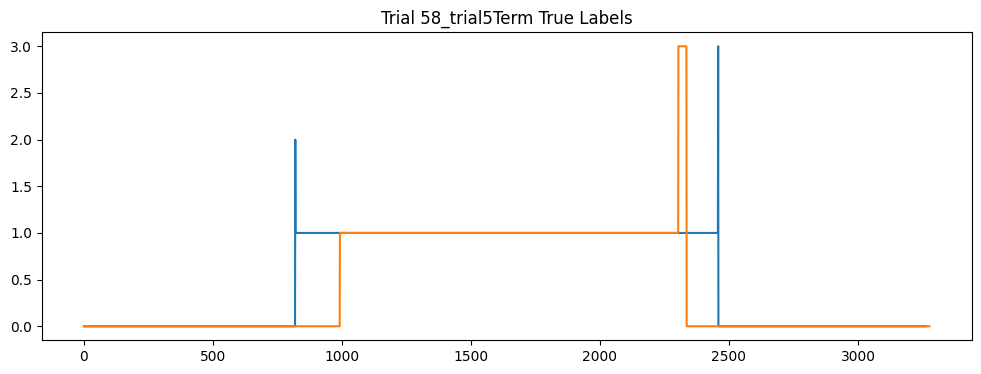

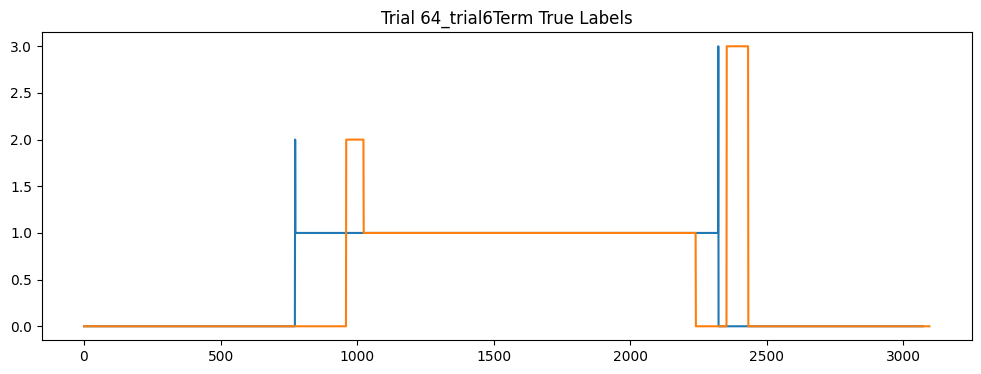

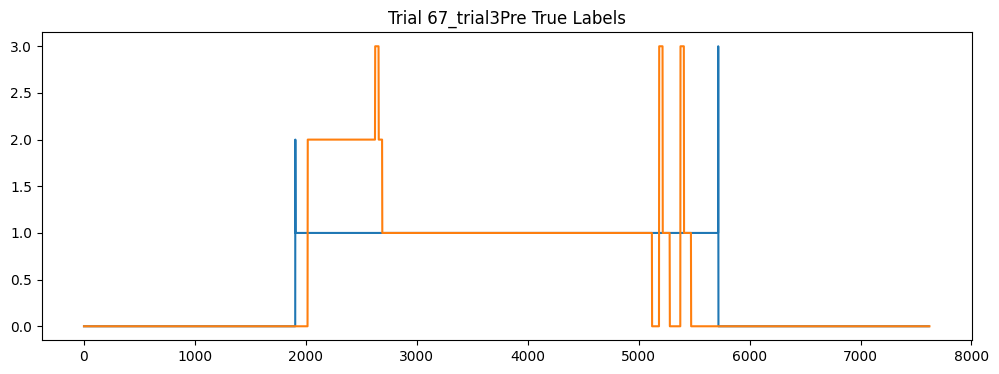

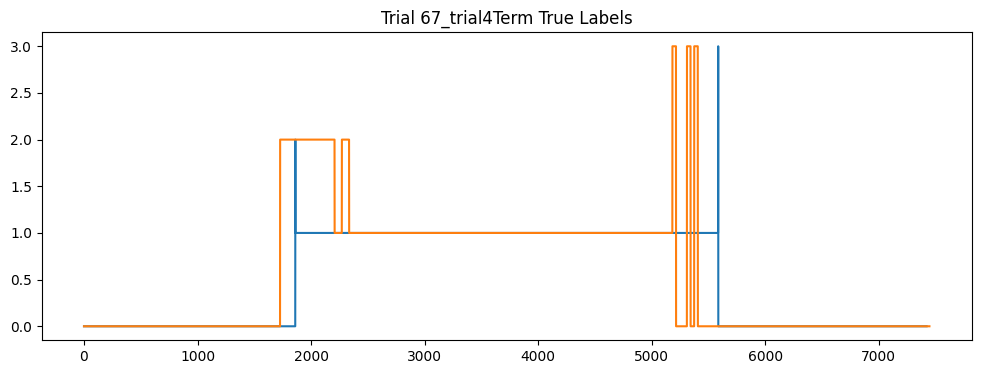

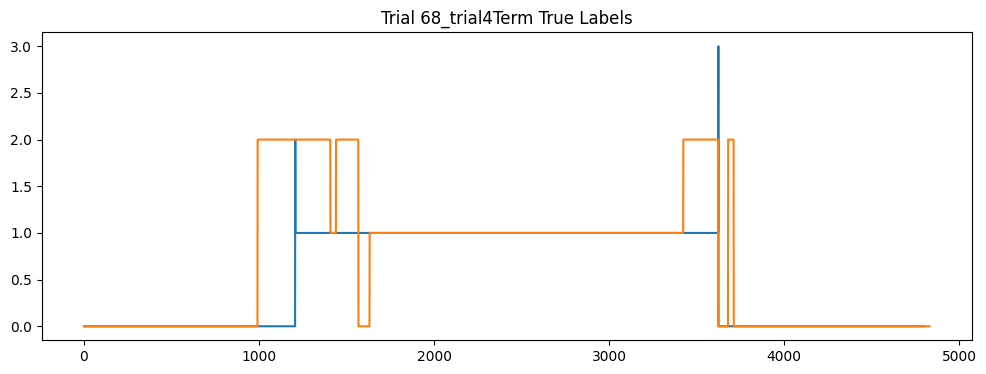

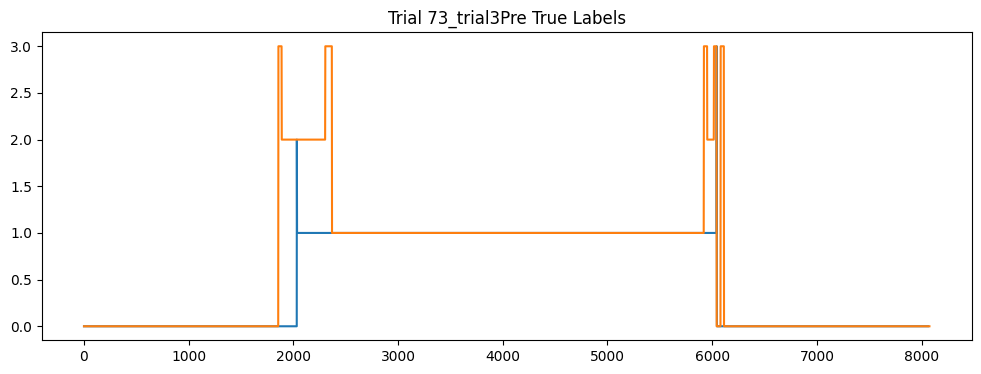

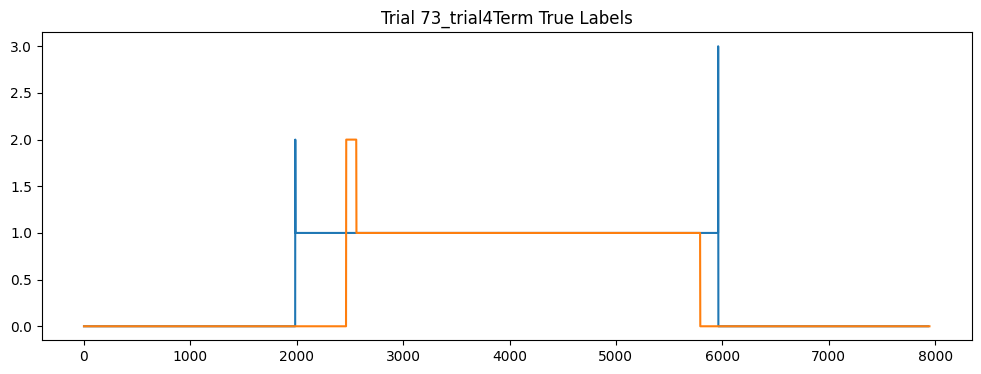

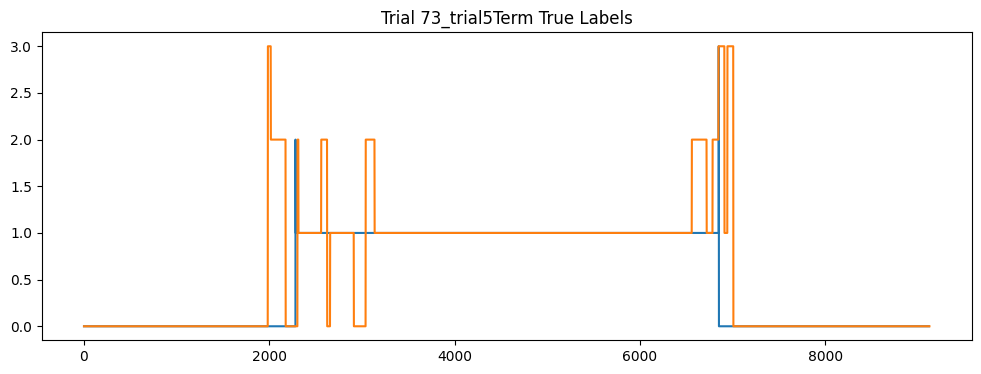

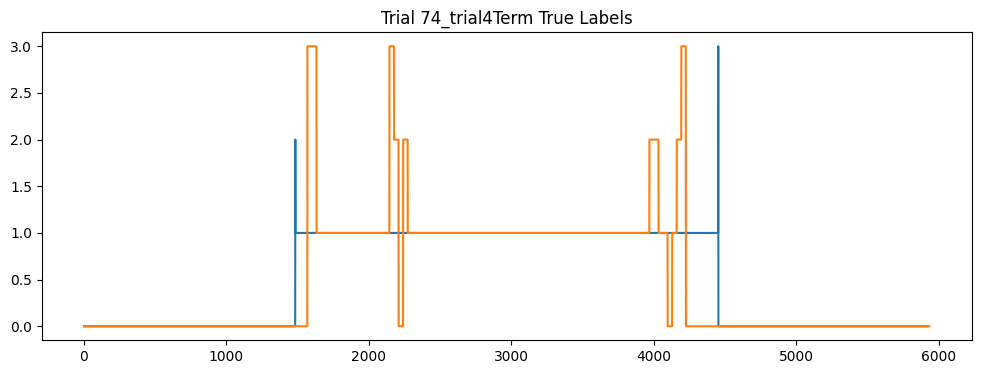

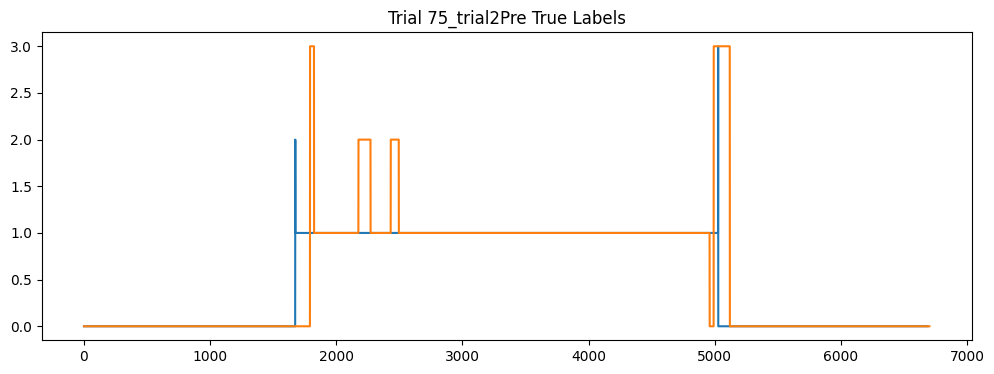

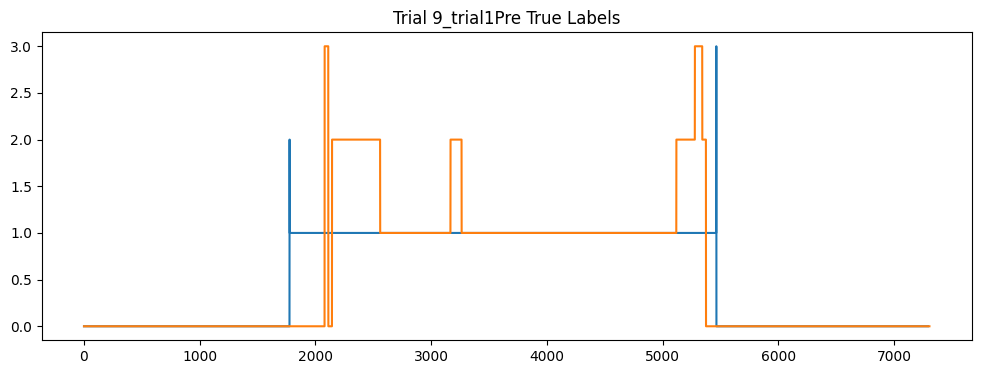

In [27]:
# OVERLAPPING TX=128, SRIDE=32 OR 1
import json
import numpy as np
import matplotlib.pyplot as plt

# Load trial length map

Y_test = np.load('NoOverlap\\Y_test.npy')
trialIDs_test = np.load('NoOverlap\\trial_ids_test.npy', allow_pickle=True)
predictions = np.load('NoOverlap\\predictions_arch1WeightsFinal.npz', allow_pickle=True)

predClassesPerWindow = predictions["pred_classes"]
predConfPerWindow = predictions["pred_confidences"]
Y_windowLabels_test = predictions["Y_windowLabels_test"]
precentageWindowMatch = np.mean(predClassesPerWindow == Y_windowLabels_test) * 100
print(f"Window-level accuracy: {precentageWindowMatch:.2f}%")

allLabelPred = []
allDistStart = []
allDistStop = []
percentageMatchSum = 0
count = 0
lengths = []
# Loop through each trial              
for trial in np.unique(trialIDs_test):
    data = np.load(f'NoOverlap\\trialProbs_arch1WeightsFinal/trial_{trial}.npz')
    avgProbs = data["avgProbs"]      # (L, 3): predicted probs per timestep
    counts = data["counts"]          # (L,)
    avgTrue = data["avgTrue"]        # could be (L,) or (L, 3)
    countsTrue = data["countsTrue"]  # (L,)
    predClassesPerWindow = data["predClassesPerWindow"]
    predConfPerWindow = data["predConfPerWindow"]
    Y_windowLabels_test = data["Y_windowLabels_test"]
    L = int(data["length"])
    
    lengths.append(L)
    
    predClasses = np.argmax(avgProbs, axis=1)
    trueClasses = avgTrue  
    
    trueClasses = fill_nans_with_next(trueClasses)
    
    # indices = np.arange(len(trueClasses))
    # goodIdxs = ~np.isnan(trueClasses)
    # trueClasses[~goodIdxs] = np.interp(indices[~goodIdxs], indices[goodIdxs], trueClasses[goodIdxs])

    # print(avgProbs.shape)
    maxProbIdx = np.argmax(avgProbs, axis=0)

    # Sanity checks
    assert predClasses.shape == (L,)
    assert trueClasses.shape == (L,)
    
    # Compare percentages timesteps in a trial that predClass matches trueClass (BEFORE Post-processing)
    percentageMatch = np.mean(predClasses == trueClasses) * 100
    percentageMatchSum = percentageMatchSum + percentageMatch
    count = count + 1
    
    plt.figure(figsize=(12,4))
    plt.plot(trueClasses, label='True')
    plt.title(f'Trial {trial} True Labels')
    plt.plot(predClasses, label='Predicted')#, alpha=0.7)
    trueStartMask = np.where(trueClasses == 2)[0]
    trueStopMask  = np.where(trueClasses == 3)[0]   
    
   
    

percentageMatchAvg = percentageMatchSum / count
print(f"Average Binary Timestep Accuracy Before Post-Processing: {percentageMatchAvg:.2f}%")
# 


In [26]:
# OVERLAPPING TX=128, SRIDE=32 OR 1
import json
import numpy as np
import matplotlib.pyplot as plt

# Load trial length map

Y_test = np.load('NoOverlap\\Y_test.npy')
trialIDs_test = np.load('NoOverlap\\trial_ids_test.npy', allow_pickle=True)
predictions = np.load('NoOverlap\\predictions_arch2WeightsFinal.npz', allow_pickle=True)

predClassesPerWindow = predictions["pred_classes"]
predConfPerWindow = predictions["pred_confidences"]
Y_windowLabels_test = predictions["Y_windowLabels_test"]
precentageWindowMatch = np.mean(predClassesPerWindow == Y_windowLabels_test) * 100
print(f"Window-level accuracy: {precentageWindowMatch:.2f}%")

allLabelPred = []
allDistStart = []
allDistStop = []
percentageMatchSum = 0
count = 0
lengths = []
# Loop through each trial              
for trial in np.unique(trialIDs_test):
    data = np.load(f'NoOverlap\\trialProbs_arch2WeightsFinal/trial_{trial}.npz')
    avgProbs = data["avgProbs"]      # (L, 3): predicted probs per timestep
    counts = data["counts"]          # (L,)
    avgTrue = data["avgTrue"]        # could be (L,) or (L, 3)
    countsTrue = data["countsTrue"]  # (L,)
    predClassesPerWindow = data["predClassesPerWindow"]
    predConfPerWindow = data["predConfPerWindow"]
    Y_windowLabels_test = data["Y_windowLabels_test"]
    L = int(data["length"])
    
    lengths.append(L)
    
    predClasses = np.argmax(avgProbs, axis=1)
    trueClasses = avgTrue  
    
    trueClasses = fill_nans_with_next(trueClasses)
    
    # indices = np.arange(len(trueClasses))
    # goodIdxs = ~np.isnan(trueClasses)
    # trueClasses[~goodIdxs] = np.interp(indices[~goodIdxs], indices[goodIdxs], trueClasses[goodIdxs])

    # print(avgProbs.shape)
    maxProbIdx = np.argmax(avgProbs, axis=0)

    # Sanity checks
    assert predClasses.shape == (L,)
    assert trueClasses.shape == (L,)
    
    # Compare percentages timesteps in a trial that predClass matches trueClass (BEFORE Post-processing)
    percentageMatch = np.mean(predClasses == trueClasses) * 100
    percentageMatchSum = percentageMatchSum + percentageMatch
    count = count + 1
    
   
    

percentageMatchAvg = percentageMatchSum / count
print(f"Average Binary Timestep Accuracy Before Post-Processing: {percentageMatchAvg:.2f}%")
# 


Window-level accuracy: 76.00%
Average Binary Timestep Accuracy Before Post-Processing: 85.47%
